## 0.0 IMPORTS

In [1]:
import pandas            as pd
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt
import inflection
import math
import datetime


from IPython.display       import Image
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from tabulate              import tabulate
from scipy                 import stats

## 0.1 Helper functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    #display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
jupyter_settings()

#CM confisuin matrix
def cramer_v( x, y ):
    cm = pd.crosstab( x, y)
    cm = cm.to_numpy()
    n = cm.sum()
    r, k = cm.shape
   
    chi2 = stats.chi2_contingency( cm )[0]  

    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( ( chi2corr/n ) / ( min( kcorr-1, rcorr-1 ) ) )



Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [3]:
df_sales_raw = pd.read_csv('dataset/train.csv', low_memory=False)
df_store_raw = pd.read_csv('dataset/store.csv', low_memory=False)

In [4]:
df_sales_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [5]:
df_store_raw.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [6]:
#merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [7]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
701152,603,5,2013-10-11,6957,860,1,1,0,0,a,a,340.0,4.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"


# 1.0 DESCRIÇÃO DOS DADOS

In [8]:
# copia de seguranca
df1 = df_raw.copy()

## 1.1 Rename Columns

In [9]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [10]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth','CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

#renomear tipo snake_case

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map( snakecase, cols_old ))

#rename columns
df1.columns = cols_new

In [11]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Data Dimensions 

In [12]:
print( 'Number of raws: {}'.format( df1.shape[0] ) )
print( 'Number of columns: {}'.format( df1.shape[1] ) )

Number of raws: 1017209
Number of columns: 18


## 1.3 Data Types

In [13]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [14]:
# data formato DATA
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [15]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

#competition_distance - NA(2642)
Indica que não possui competidor próximo ou ele está muito afastado!!

In [16]:
#distância máxima 
df1['competition_distance'].max()

75860.0

In [17]:
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

In [18]:
df1['competition_distance'].isna().sum()

0

competition_open_since_month    323348 <br>
Mes e ano que o concorrente mais próximo foi aberto<br>
Razões de colunas vazias:<br>
1) Não possui concorrente próximo <br>
2) Ou o concrrente abriu muito antes dos dados serem coletados ou esqueceram de anotar a data <br>
Solução: supor a data de abertura como sendo a data da venda, ou seja, competidor acabou de chgar e ainda não consegue influenciar nas vendas.

In [19]:
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) 
                                                                           else x['competition_open_since_month'], axis=1 )

#competition_open_since_year     323348

df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) 
                                                                           else x['competition_open_since_year'], axis=1 )

pomo2 - extensão de uma promocão já existente
solução igual a anterior - substituir pela data da venda

In [20]:
#promo2_since_week 508031
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) 
                                                                           else x['promo2_since_week'], axis=1 )

#promo2_since_year 508031

df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) 
                                                                           else x['promo2_since_year'], axis=1 )

In [21]:
df1.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
768945,381,7,2013-08-11,0,0,0,0,0,0,a,a,1800.0,11.0,2006.0,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [22]:
month_map = {1: 'Jan', 2: 'Fev', 3:'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 
             7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec' }
df1['promo_interval'].fillna( 0, inplace=True )

df1['month_map'] = df1['date'].dt.month.map( month_map ) 

In [23]:
df1.sample(5).T

,561540,481907,361462,910906,936275
store,366,1013,871,737,461
day_of_week,4,6,3,6,4
date,2014-02-13 00:00:00,2014-04-26 00:00:00,2014-08-20 00:00:00,2013-04-06 00:00:00,2013-03-14 00:00:00
sales,5631,2345,5232,4186,3344
customers,604,274,394,711,405
open,1,1,1,1,1
promo,0,0,1,0,0
state_holiday,0,0,0,0,0
school_holiday,0,0,1,0,0
store_type,d,a,d,a,d


In [24]:
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval']==0 
                                            else 1 if x['month_map'] in x['promo_interval'].split( ',' ) 
                                            else 0, axis=1 )

In [25]:
df1.sample(5).T

,576446,595126,862509,61499,734506
store,777,502,285,175,507
day_of_week,5,2,7,6,3
date,2014-01-31 00:00:00,2014-01-14 00:00:00,2013-05-19 00:00:00,2015-06-06 00:00:00,2013-09-11 00:00:00
sales,3899,8996,0,6307,8953
customers,335,1430,0,756,694
open,1,1,0,1,1
promo,0,0,0,0,1
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,0
store_type,d,a,a,c,a


In [26]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change types

In [27]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [28]:
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )

In [29]:
df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

In [30]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descriptive Statistical

In [31]:
# selicionar as variaveis numericas
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
num_attributes.head()

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
0,1,5,5263,555,1,1,1,1270.0,9,2008,0,31,2015,0
1,2,5,6064,625,1,1,1,570.0,11,2007,1,13,2010,1
2,3,5,8314,821,1,1,1,14130.0,12,2006,1,14,2011,1
3,4,5,13995,1498,1,1,1,620.0,9,2009,0,31,2015,0
4,5,5,4822,559,1,1,1,29910.0,4,2015,0,31,2015,0


In [32]:
# selcionar as variáveis categóricas
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64'] )
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


## 1.7.1 Numerical Attributes

In [33]:
# central tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, Kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( np.min ) ).T
d3 = pd.DataFrame( num_attributes.apply( np.max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

#concatenate
metrics = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()

In [34]:
metrics.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median','std', 'skew', 'kurtosis'] 
metrics

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

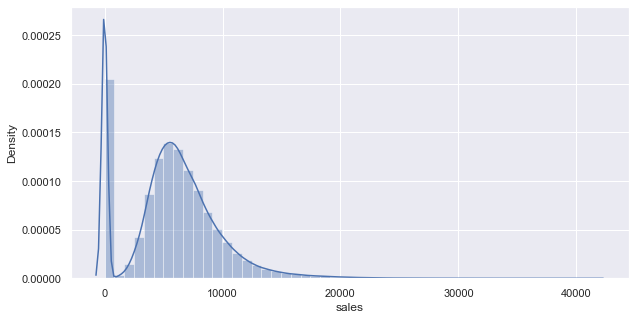

In [35]:
plt.figure( figsize=(10,5) )
sns.distplot( df1['sales'] )

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

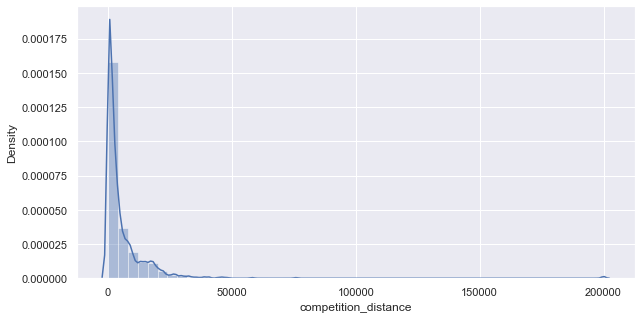

In [36]:
plt.figure( figsize=(10,5) )
sns.distplot( df1['competition_distance'] )

## 1.7.2 Categorical Attibutes 

In [37]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='state_holiday', ylabel='sales'>

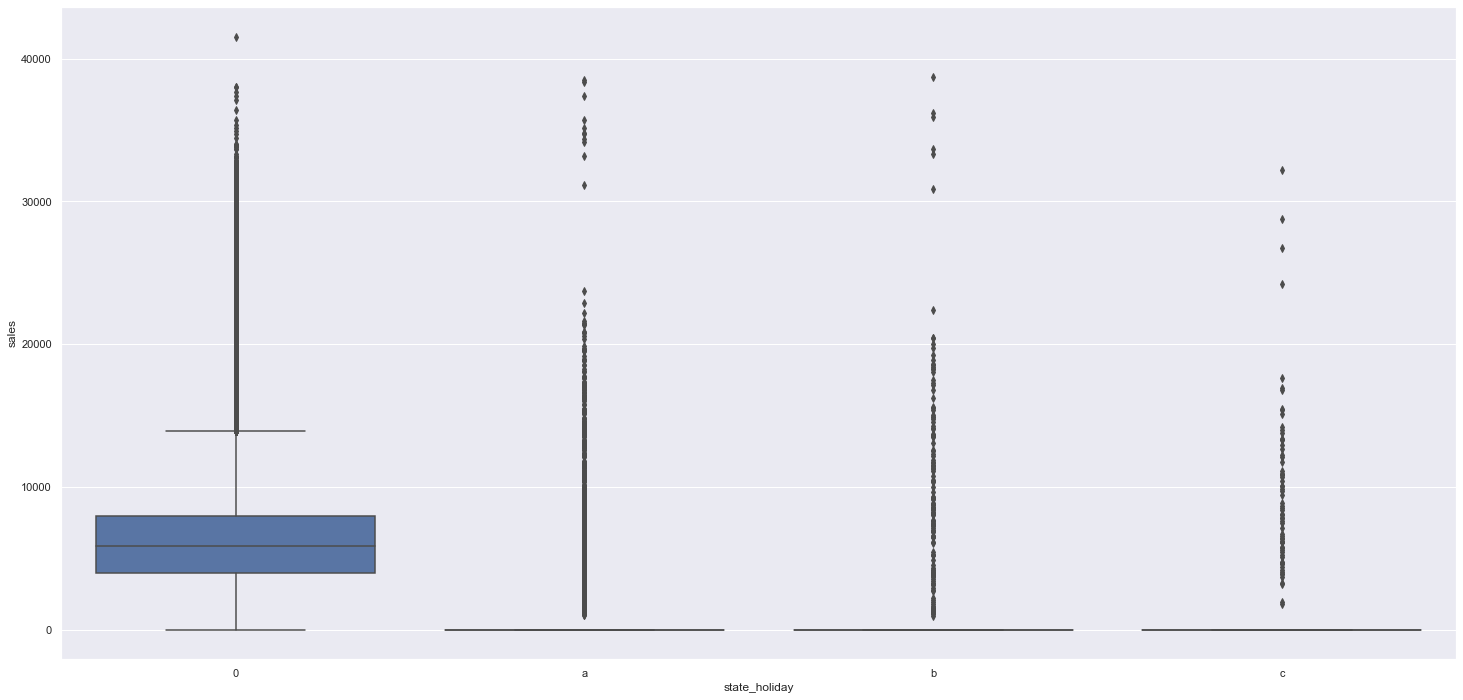

In [38]:
sns.boxplot( x='state_holiday', y='sales', data=df1 )

<AxesSubplot:xlabel='state_holiday', ylabel='sales'>

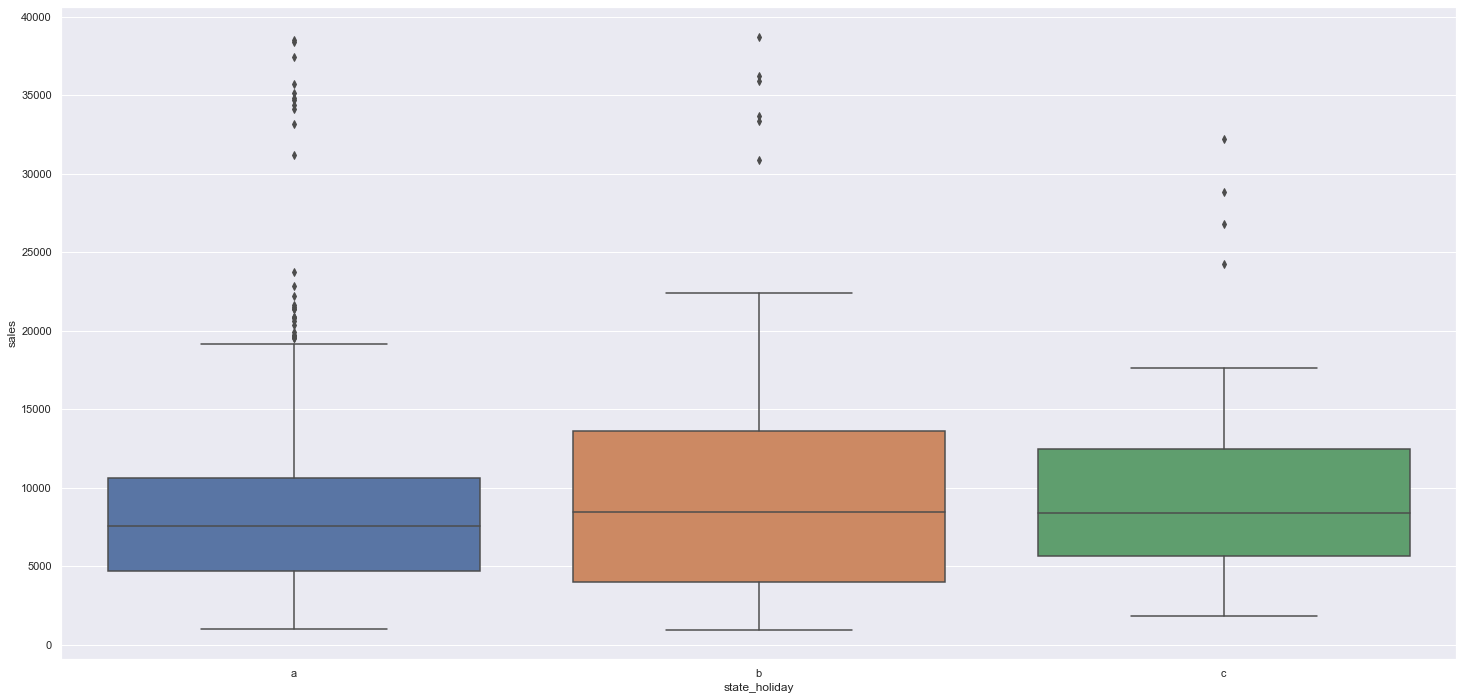

In [39]:
# excluir os dias que não tiveram vendas/loja fechada 
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]
sns.boxplot( x='state_holiday', y='sales', data=aux1 )

Organizar boxplot, visualizar como as vendas então distribuídas pelas variáveis categóricas.

<AxesSubplot:xlabel='assortment', ylabel='sales'>

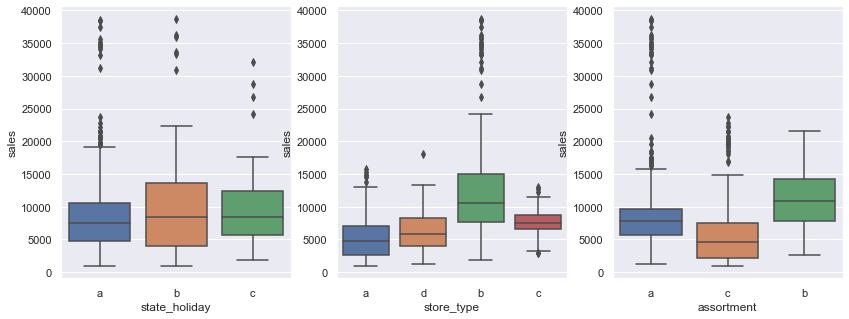

In [40]:
plt.figure( figsize=(14,5) )
plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=aux1 )
plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux1 )
plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux1 )

## 2.0 FEATURE ENGINEERING

In [41]:
df2 = df1.copy()

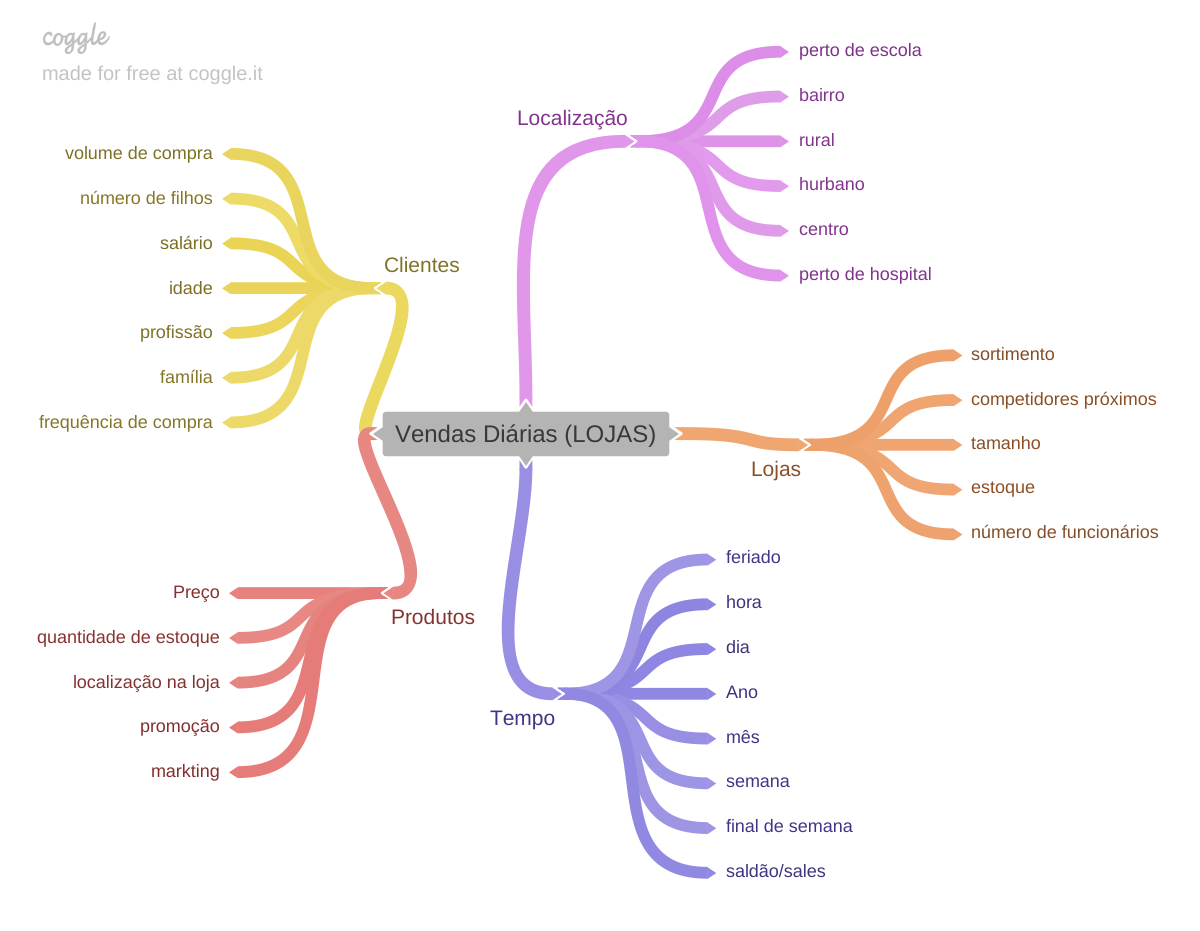

In [42]:
Image( 'img/MindMapHypotesis.png' )

## 2.1 Criação das Hipóteses

### 2.1.1 As hipóteses das lojas

**1.** Lojas com maior quadro de funcionárias deveriam vender mais

**2.** Lojas com maior estoque deveriam vender mais

**3.** Lojas com maior porte(tamanho) deveriam vender mais

**4.** Lojas com maior sortimento deveriam vender mais

**5.** Lojas com competidores mais próximos deveriam vender menos

**6.** Lojas com competidores à mais tempo ddeveriam vender mais

### 2.1.2 As hipóteses do produto

**1.** Lojas que investem mais em markting deveriam vender mais

**2.** Lojas que expõe mais produtos em vitrines deveriam vender mais

**3.** Lojas com preço menor de produtos deveriam vender mais

**4.** Lojas com promocões mais agressivas deveriam vender mais

**5.** Lojas com promocões ativas por mais tempo deveriam vender mais

**6.** Lojas com mais dias de promoção deveriam vender mais

**7.** Lojas com mais promoções consecutivas deveriam vender mais

### 2.1.3 As hipóteses do Tempo - Temporal

**1.** Lojas abertas no feriado de Natal deveriam vender mais

**2.** Lojas deveriam vender mais ao longo dos anos

**3.** Lojas deveriam vender mais no segundo semestre do ano

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês

**5.** Lojas deveriam vender menos aos finais de semana

**6.** Lojas deveriam vender menos durante os feriados escolares

## 2.2 Lista Final de Hipóteses

Começar com as hipótese que possuem dados disponíveis para validação

**1.** Lojas com maior sortimento deveriam vender mais

**2.** Lojas com competidores mais próximos deveriam vender menos

**3.** Lojas com competidores à mais tempo ddeveriam vender mais

**4.** Lojas com promocões ativas por mais tempo deveriam vender mais

**5.** Lojas com mais dias de promoção deveriam vender mais

**6.** Lojas com mais promoções consecutivas deveriam vender mais

**7.** Lojas abertas no feriado de Natal deveriam vender mais

**8.** Lojas deveriam vender mais ao longo dos anos

**9.** Lojas deveriam vender mais no segundo semestre do ano

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês

**11.** Lojas deveriam vender menos aos finais de semana

**12.** Lojas deveriam vender menos durante os feriados escolares

## 2.3 Feature Engineering

2.3.1 Derivar ano, mês, semana, semana do ano, dia, year week variável date

In [43]:
#year
df2['year'] = df2['date'].dt.year

#month
df2['month'] = df2['date'].dt.month

#week
df2['week'] = df2['date'].dt.week

#week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

#day
df2['day'] = df2['date'].dt.day

#year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W')

<ipython-input-43-cf8c83377d02>:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df2['week'] = df2['date'].dt.week
<ipython-input-43-cf8c83377d02>:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


In [44]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,0,0,0,0,0
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


2.3.2 Criar a variável competition_time_month que será o tempo de concorrrência em mês. Juntar para data competition o mês (competition_since_month) e ano (competition_since_year) da competition e extrair a data da venda (date)

In [45]:
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1 )

In [46]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,0,0,0,0,0
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


In [47]:
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days).astype( int )

In [48]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,0,0,0,0,0
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


Criar a variável promo_time_week que será o tempo de promoção em semanas. Juntar para data promo2_since o ano (promo2_since_year) e semana (promo2_since_year) e extrair a data da venda (date)

In [49]:
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )

df2['promo_since'].head()

0    2015-31
1    2010-13
2    2011-14
3    2015-31
4    2015-31
Name: promo_since, dtype: object

In [50]:
#reescrever promo_since como data
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days =7 ))
df2['promo_since'].head()

0   2015-07-27
1   2010-03-22
2   2011-03-28
3   2015-07-27
4   2015-07-27
Name: promo_since, dtype: datetime64[ns]

In [51]:
#criar variável promo_time_week - tempo que a promoção está ativa em semanas
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days).astype( int )
df2['promo_time_week'].head()

0      0
1    279
2    226
3      0
4      0
Name: promo_time_week, dtype: int64

2.3.4 Renomear o assortment: a = basic, b = extra, c = extended

In [52]:
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x =='b' else 'extended' )
df2['assortment'].head()

0       basic
1       basic
2       basic
3    extended
4       basic
Name: assortment, dtype: object

2.3.4 Renomear o state_holiday: a = public_holiday, b = easter_holiday, c = christmas

In [53]:
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )
df2['state_holiday'].head()

0    regular_day
1    regular_day
2    regular_day
3    regular_day
4    regular_day
Name: state_holiday, dtype: object

# 3.0 FILTRAGEM DE VARIÁVEIS

In [54]:
df3 = df2.copy()

In [55]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,week,week_of_year,day,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,31,2015-30,2015-04-01,4,2015-07-27,0


In [56]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval', 'month_map', 'is_promo', 'year',
       'month', 'week', 'week_of_year', 'day', 'year_week',
       'competition_since', 'competition_time_month', 'promo_since',
       'promo_time_week'],
      dtype='object')

## 3.1 Filtragem das linhas

A coluna open idica se a loja está aberta ou fechada. Loja fechada não vende. Como queremos a previsão de vendas, nõa iremos utilizar as linhas nos quais as lojas estão fechadas. Portanto devemos selcionar open != 0.<br>
Quando as lojas estão fechadas temos sales = 0. Portanto devemos selecionar sales maior que zero.

In [57]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0 )]

## 3.1 Seleção das Colunas

'Customers' é uma variável que não é possível de prever. Paaa a previsão dessa variável teríamos que fazer um moldelo separado antes de usá-la. 'Customers' é uma "restrição de negócio".<br>
Uma outra coluna que também não tem funcionalidade é a open, afinal filtramos todas as lojas abertas, portanto todos os valores de open são igual a 1. Não faz sentido mantê-la.<br>
Colunas que utilizamos para derivar variáveis ou utilizadas como auxiliares (ex: 'promo_interval' da derivamos 'is promo' e a month_map).

In [58]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 ) 

In [59]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'week', 'week_of_year', 'day', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 EDA - ANÁLISE EXPLORATÓRIA DOS DADOS

In [60]:
df4 = df3.copy()

## 4.1 Análise Univariada

## 4.1.1 Response variable

Analise da variável resposta vendas 'sales'.

<Figure size 864x432 with 0 Axes>

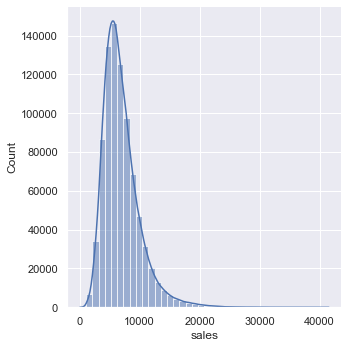

In [61]:
plt.figure(figsize=(12,6))
sns.displot( df4['sales'],  bins=40, kde=True )

Distribuicão em formato de sino, com kurtose e skew deslocad para esquerda, positiva, porém não está centrada. Distribuiçã próxima de uma distribuição normal.

## 4.1.2 Numerical Variable

array([[<AxesSubplot:title={'center':'store'}>,
        <AxesSubplot:title={'center':'day_of_week'}>,
        <AxesSubplot:title={'center':'sales'}>,
        <AxesSubplot:title={'center':'customers'}>],
       [<AxesSubplot:title={'center':'open'}>,
        <AxesSubplot:title={'center':'promo'}>,
        <AxesSubplot:title={'center':'school_holiday'}>,
        <AxesSubplot:title={'center':'competition_distance'}>],
       [<AxesSubplot:title={'center':'competition_open_since_month'}>,
        <AxesSubplot:title={'center':'competition_open_since_year'}>,
        <AxesSubplot:title={'center':'promo2'}>,
        <AxesSubplot:title={'center':'promo2_since_week'}>],
       [<AxesSubplot:title={'center':'promo2_since_year'}>,
        <AxesSubplot:title={'center':'is_promo'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

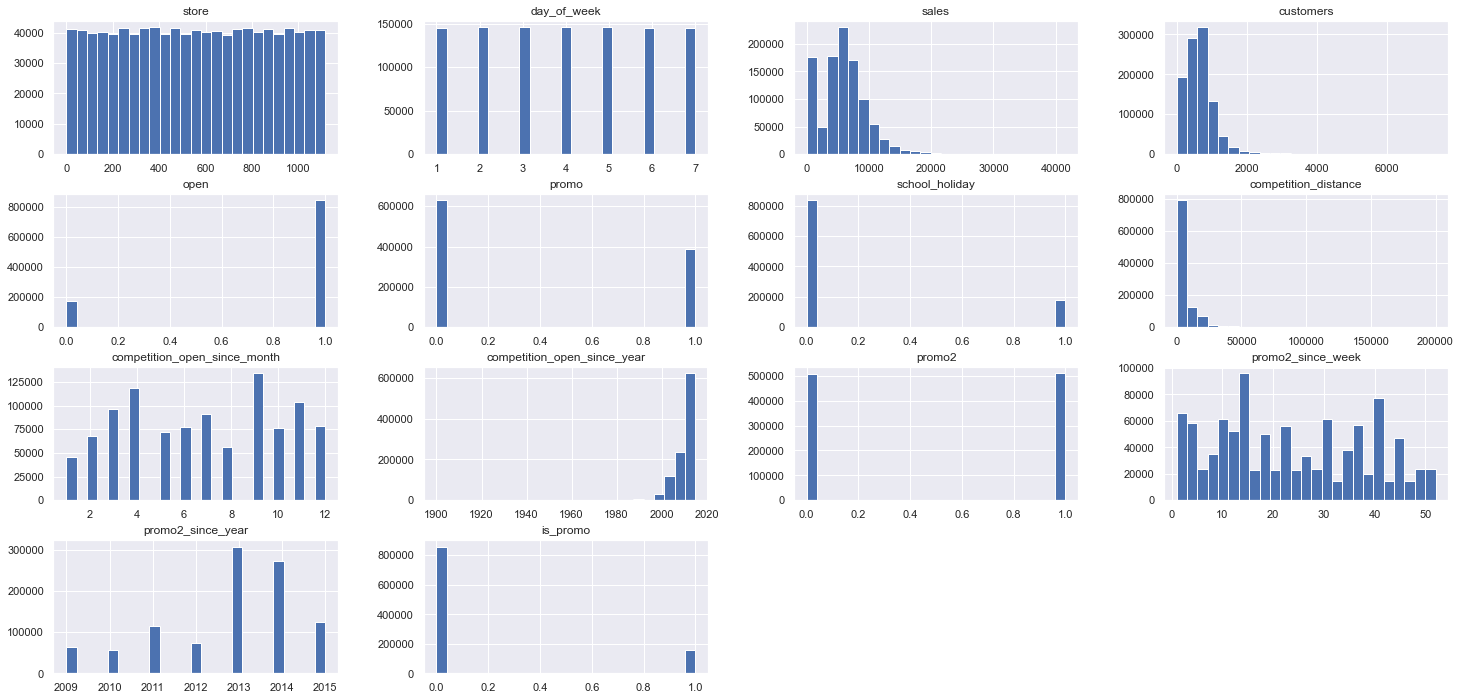

In [62]:
num_attributes.hist( bins = 25)

## 4.1.3 Categorical Variable

In [63]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [64]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sales', ylabel='Density'>

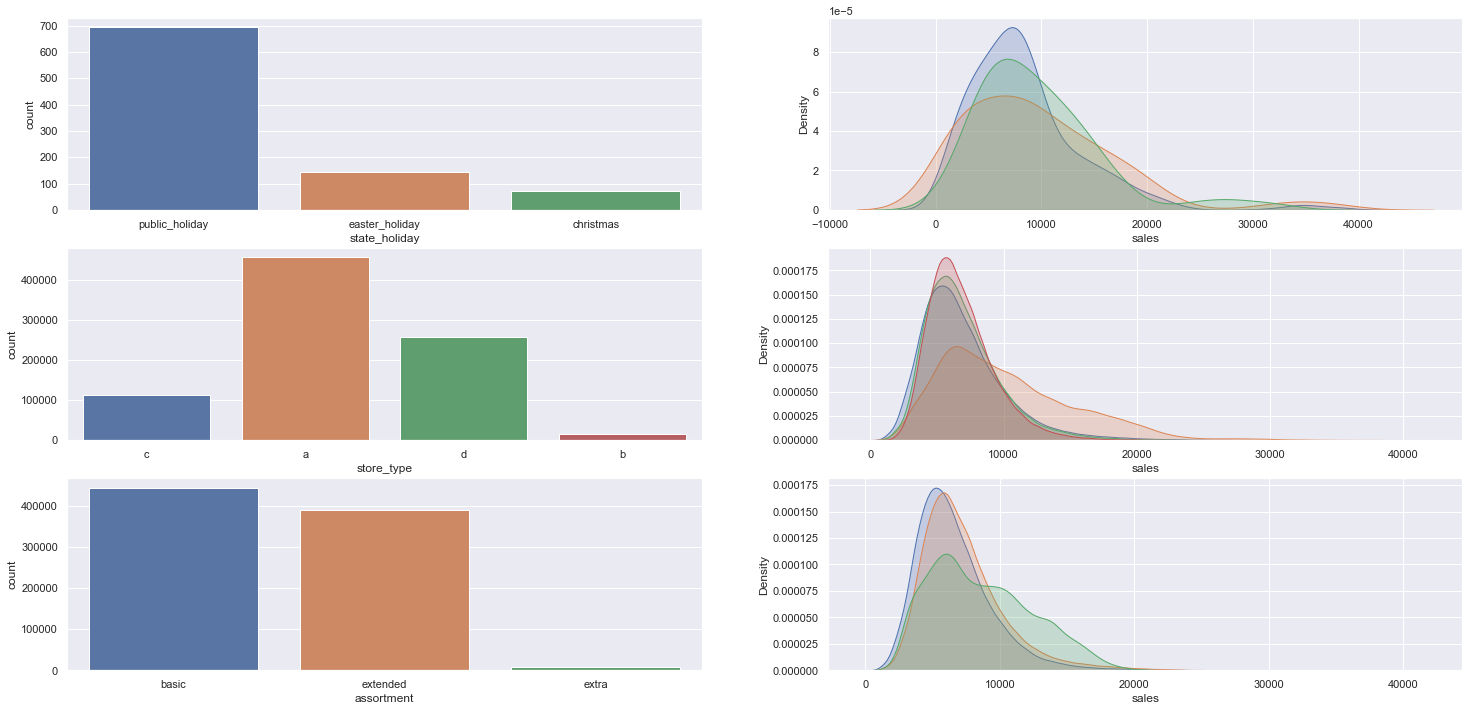

In [65]:
#state_holiday - volume de vendas por feriado
plt.subplot( 3, 2, 1 )
a =  df4[df4['state_holiday'] != 'regular_day']
sns.countplot( a['state_holiday'] ) 

plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True )

#store_type
plt.subplot( 3, 2, 3 )
sns.countplot( df4['store_type'] ) 

plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True )

#assortmet
plt.subplot( 3, 2, 5 )
sns.countplot( df4['assortment'] ) 

plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True )

## 4.2 Análise Bivariada

### **H1** Lojas com maior sortimento deveriam vender mais
Em relação ao volume de vendas, vemos um maior volume para lojas com sortimentos do tipo basic e extended. Esse resultado era de se esperar pois há também um maior volume dessas lojas quando comparadas a do tipo extra.<br>
No entando, quando analisamos a média de vendas, vemos que aquelas com soritmento tipo extra possui uma média de venda maior, seguida pela extended e basic, confirmando a hipótese.

In [66]:
df4['assortment'].value_counts()

basic       444875
extended    391254
extra         8209
Name: assortment, dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

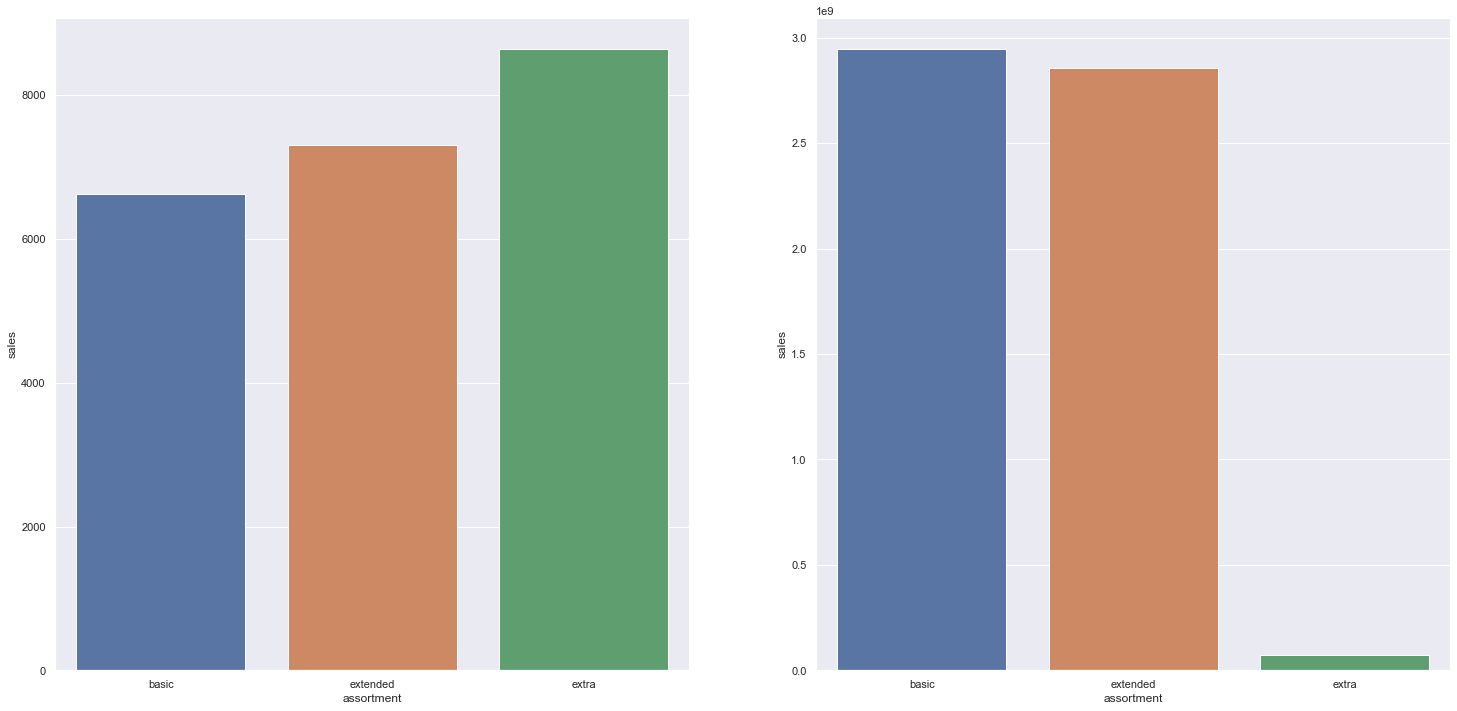

In [67]:
# Média de vendas por sortimento
plt.subplot( 1 ,2, 1 )
aux1_1 = df4[['assortment', 'sales']].groupby('assortment').mean().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1_1, )

# Volume de vendas por sortimento
plt.subplot( 1 ,2, 2 )
aux1_2 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1_2, )

In [68]:
aux2 = df4[['year_week','assortment', 'sales']].groupby(['year_week','assortment']).mean().reset_index()
aux2.head()

,year_week,assortment,sales
0,2013-00,basic,5642.277194
1,2013-00,extended,6094.001471
2,2013-00,extra,5282.431373
3,2013-01,basic,7307.459961
4,2013-01,extended,7553.623270


<AxesSubplot:xlabel='year_week'>

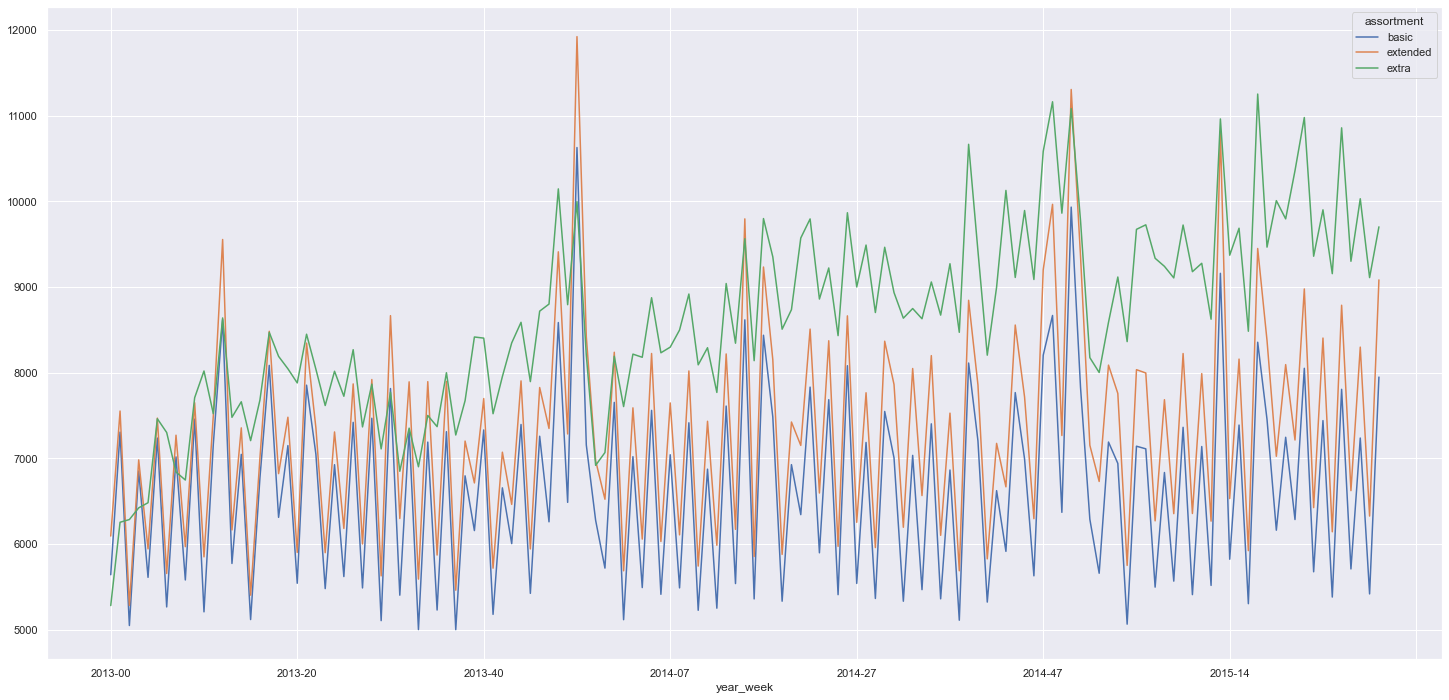

In [69]:
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()


<AxesSubplot:xlabel='year_week'>

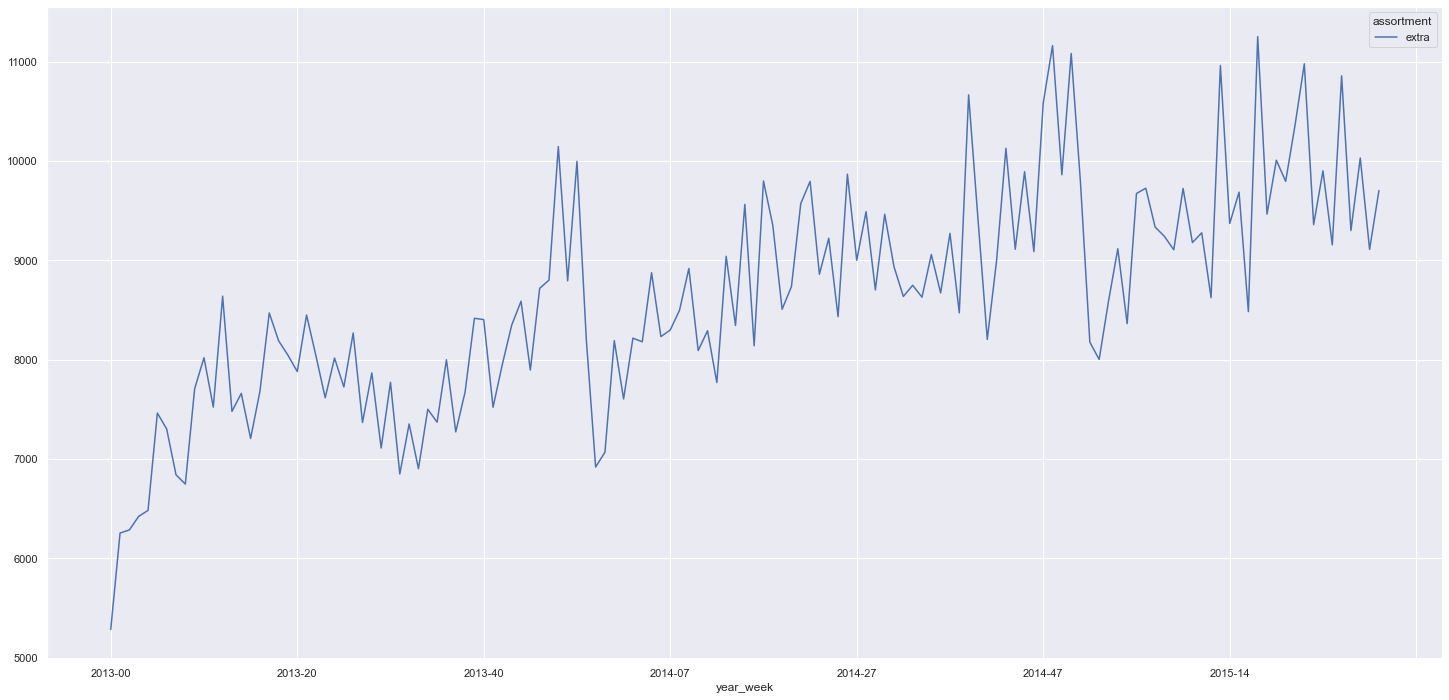

In [70]:
aux3 = aux2[aux2['assortment']=='extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()

### **H2**. Lojas com competidores mais próximos deveriam vender menos
Quando olhamos para o valor média das vendas não vemos muita relação entre vendas e proximidade dos competidores. No entanto, quando olhamos para o volume de vendas podemos notas que lojas com competidores mais próximos possui maior volume venda. Uma explicação seria o maior volume de lojas com competidores próximos.

Text(0.5, 1.0, 'Volume de vendas')

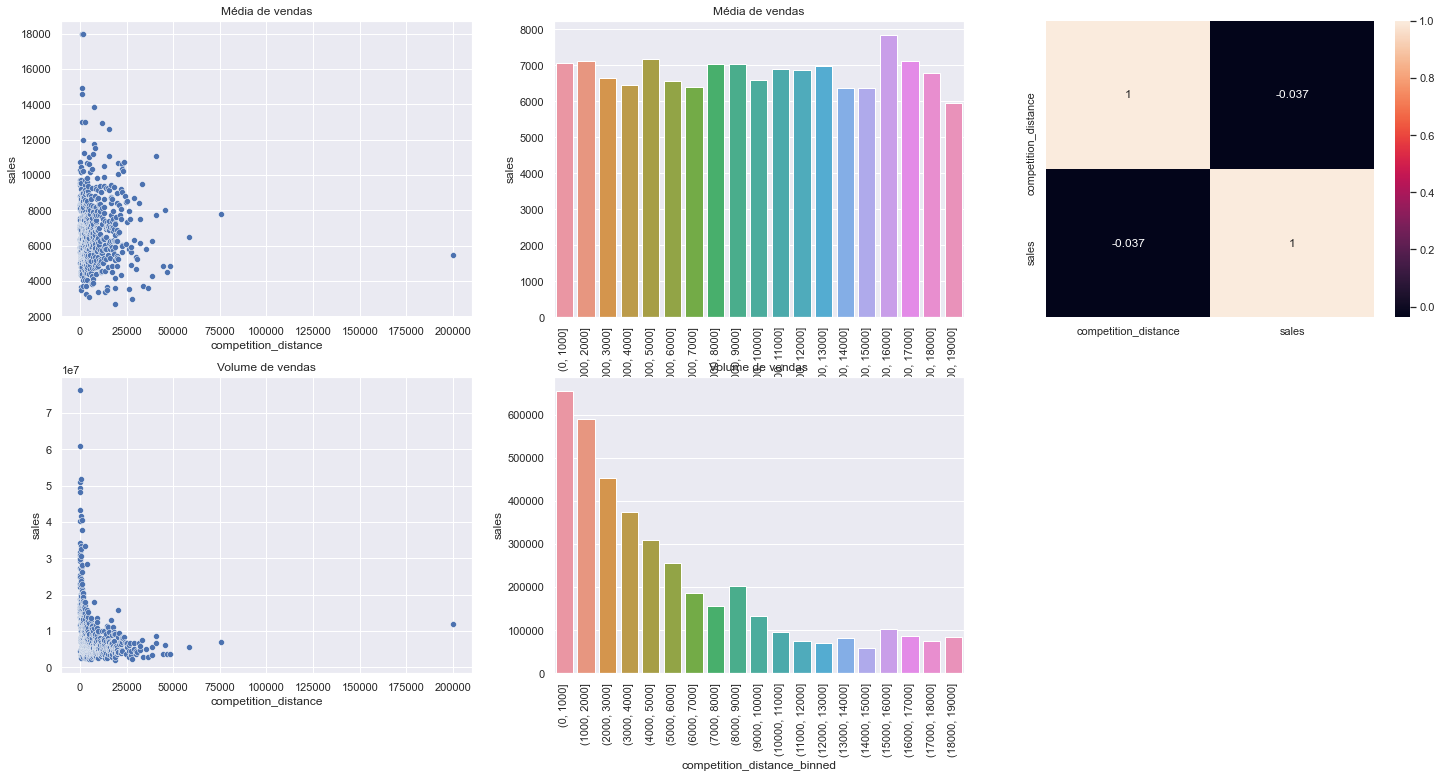

In [71]:
#Média de vendas em função da distancia dos competidores
aux2_1=df4[['competition_distance', 'sales']].groupby('competition_distance').mean().reset_index()

plt.subplot(2,3,1)
sns.scatterplot(x='competition_distance', y='sales', data=aux2_1)
plt.title('Média de vendas')

plt.subplot( 2, 3, 2 )
bins = list( np.arange(0, 20000, 1000))
aux2_1['competition_distance_binned'] = pd.cut(aux2_1['competition_distance'], bins=bins)
aux2_2=aux2_1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').mean().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2_2 )
plt.xticks( rotation=90 )
plt.title('Média de vendas')

plt.subplot( 2, 3, 3 ) 
sns.heatmap( aux2_1.corr(method='pearson'), annot=True )

#Volume de vendas em função da distancia dos competidores
aux2_3=df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot( 2, 3, 4 )
sns.scatterplot(x='competition_distance', y='sales', data=aux2_3)
plt.title('Volume de vendas')

plt.subplot( 2, 3, 5 )
bins = list( np.arange(0, 20000, 1000))
#aux2_1['competition_distance_binned'] = pd.cut(aux2_1['competition_distance'], bins=bins)
aux2_4=aux2_1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2_4 )
plt.xticks( rotation=90 )
plt.title('Volume de vendas')

In [72]:
aux2_1['competition_distance_binned'].value_counts()

(0, 1000]         93
(1000, 2000]      83
(2000, 3000]      68
(3000, 4000]      58
(4000, 5000]      43
(5000, 6000]      39
(6000, 7000]      29
(8000, 9000]      29
(7000, 8000]      22
(9000, 10000]     20
(10000, 11000]    14
(18000, 19000]    14
(13000, 14000]    13
(15000, 16000]    13
(16000, 17000]    12
(11000, 12000]    11
(17000, 18000]    11
(12000, 13000]    10
(14000, 15000]     9
Name: competition_distance_binned, dtype: int64

### **H3** Lojas com competidores à mais tempo deveriam vender mais
Falsa: lojas com competidores a mais tempo vendem menos.

<AxesSubplot:>

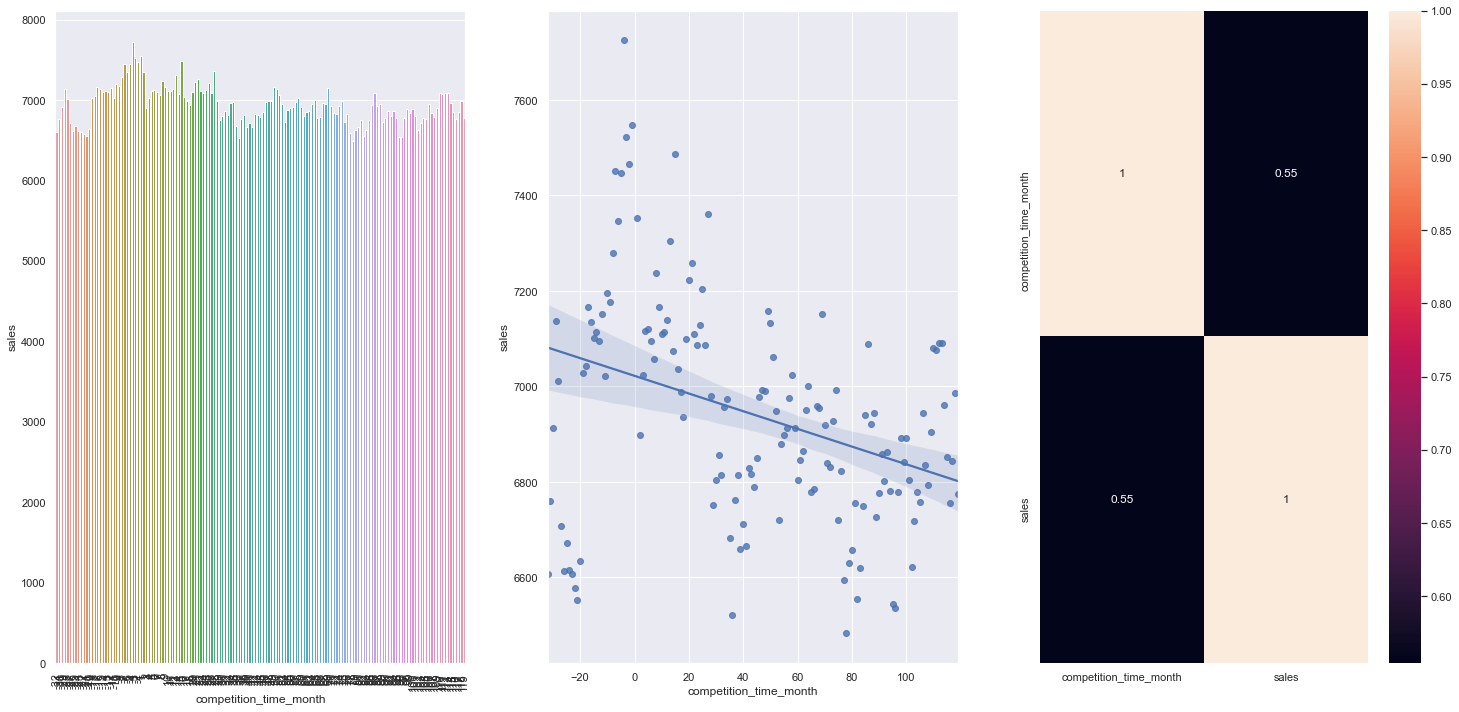

In [73]:
aux3_1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').mean().reset_index()

plt.subplot( 1, 3, 1 )
aux3_2 = aux3_1[( aux3_1['competition_time_month'] < 120 ) & ( aux3_1['competition_time_month'] != 0  )]
sns.barplot(x = 'competition_time_month', y='sales', data=aux3_2)
plt.xticks( rotation=90 )
 
plt.subplot( 1, 3, 2 )    
sns.regplot(x = 'competition_time_month', y='sales', data=aux3_2)

plt.subplot( 1, 3, 3 ) 
sns.heatmap( aux3_1.corr(method='pearson'), annot=True )

Influencia do tempo de competição na venda = quanto menor o tempo de competição maior a venda.

### H4. Lojas com promocões ativas por mais tempo deveriam vender mais
 FALSA - Lojas com promoções ativas por mais tempo venem MENOS.

<AxesSubplot:>

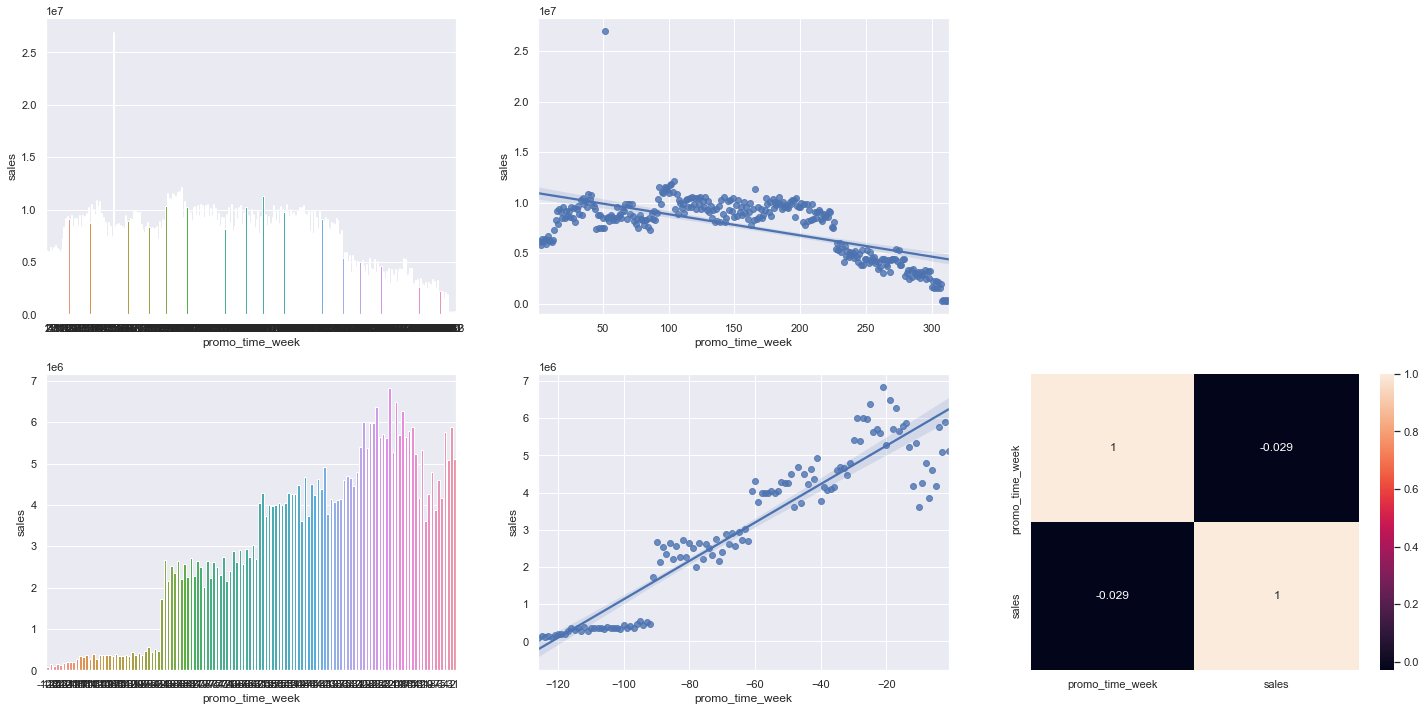

In [74]:
aux4_1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()
#sns.barplot( x='promo_time_week', y='sales', data=aux4_1 )


aux4_2 = aux4_1[aux4_1['promo_time_week'] > 0 ] # promo extendida
aux4_3 = aux4_1[aux4_1['promo_time_week'] < 0 ] # promo extendida

plt.subplot( 2,3,1 )
sns.barplot( x='promo_time_week', y='sales', data=aux4_2 )

plt.subplot(2,3,2 )
sns.regplot( x='promo_time_week', y='sales', data=aux4_2 )

plt.subplot( 2,3,4 )
sns.barplot( x='promo_time_week', y='sales', data=aux4_3 )

plt.subplot( 2,3,5 )
sns.regplot( x='promo_time_week', y='sales', data=aux4_3 )

plt.subplot( 2,3,6) 
sns.heatmap( aux4_1.corr(method='pearson'), annot=True )

### <s> H5. Lojas com mais dias de promoção deveriam vender mais</s>


### H6. Lojas com mais promoções consecutivas deveriam vender mais
FALSA: Loja com mais promoções consecutivas vendem menos!

In [75]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).mean().reset_index()

,promo,promo2,sales
0,0,0,6328.187633
1,0,1,5529.566684
2,1,0,8618.452062
3,1,1,7836.672987


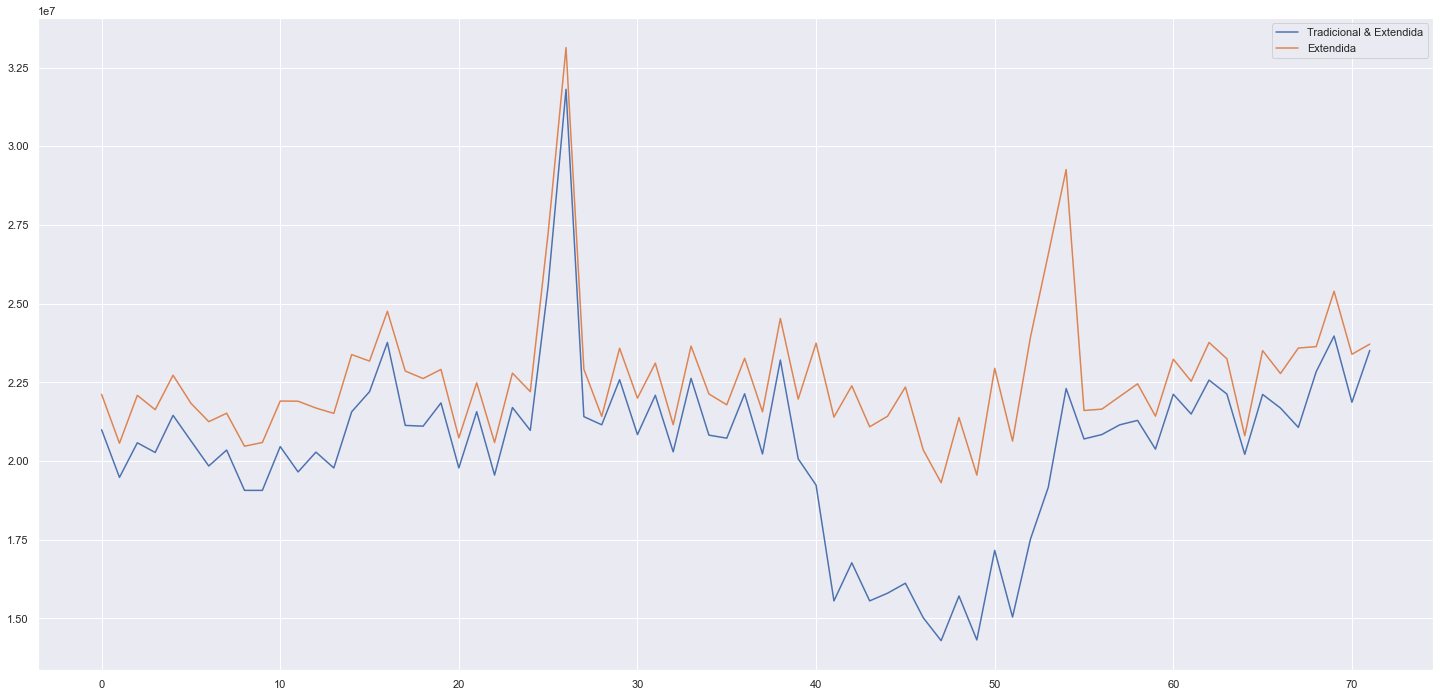

In [76]:
aux6_1 = df4[( df4['promo']==1) & (df4['promo2']==1 )][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux6_1.plot()

aux6_2 = df4[( df4['promo']==1) & (df4['promo2']==0 )][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux6_2.plot(ax=ax)
ax.legend( labels=['Tradicional & Extendida', 'Extendida'] )

### H7. Lojas abertas no feriado de Natal deveriam vender mais
Em 2013 o feriado da páscoa apresentou maior média de vendas.<br>
Em 2014 o Natal apresentou maior média de vendas.<br>
Nos últimos anos a páscoa apresenta maior média das vendas.

In [77]:
# venda média por feriado
df4[['state_holiday', 'sales']].groupby('state_holiday').mean().reset_index()

,state_holiday,sales
0,christmas,9743.746479
1,easter_holiday,9887.889655
2,public_holiday,8487.471182
3,regular_day,6953.960229


<AxesSubplot:xlabel='state_holiday', ylabel='sales'>

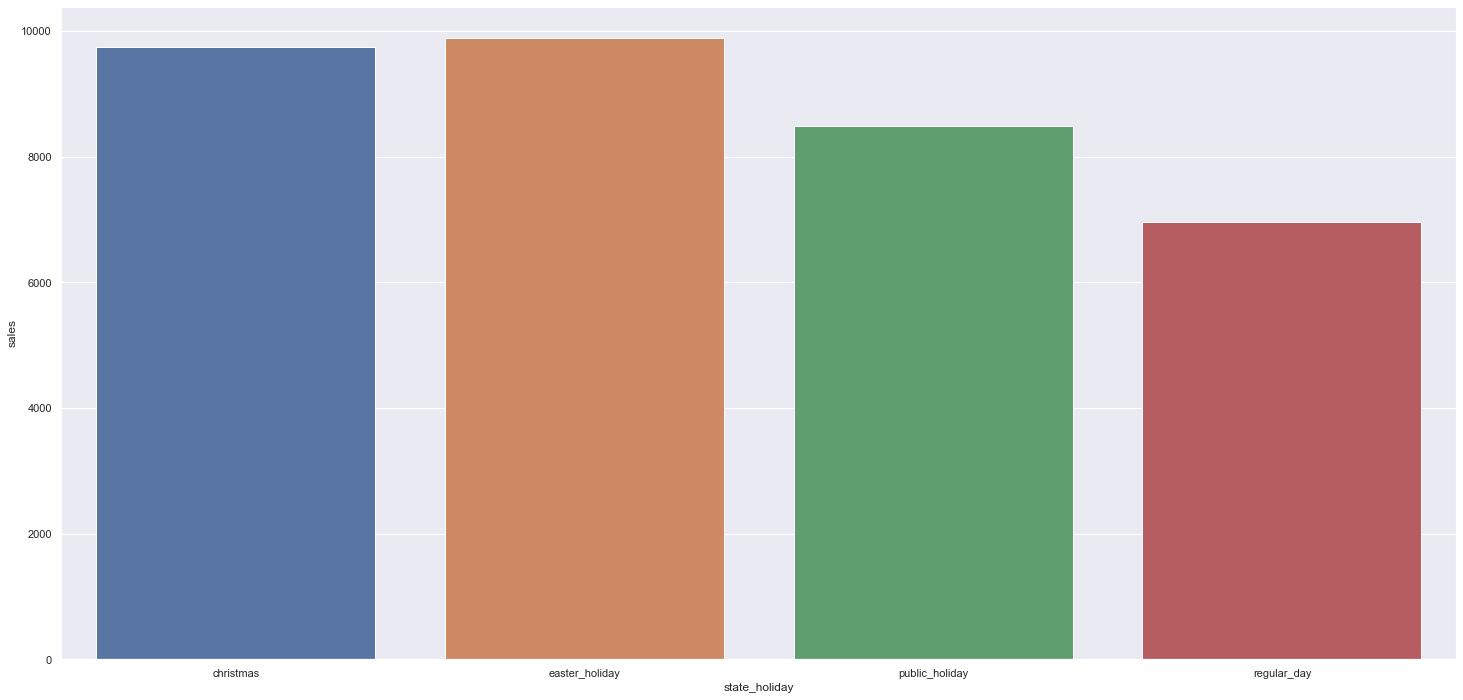

In [78]:
aux7_1 = df4[['state_holiday', 'sales']].groupby('state_holiday').mean().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux7_1)

In [79]:
#volume de vendas por feriado
df4[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()

,state_holiday,sales
0,christmas,691806
1,easter_holiday,1433744
2,public_holiday,5890305
3,regular_day,5865164768


<AxesSubplot:xlabel='state_holiday', ylabel='sales'>

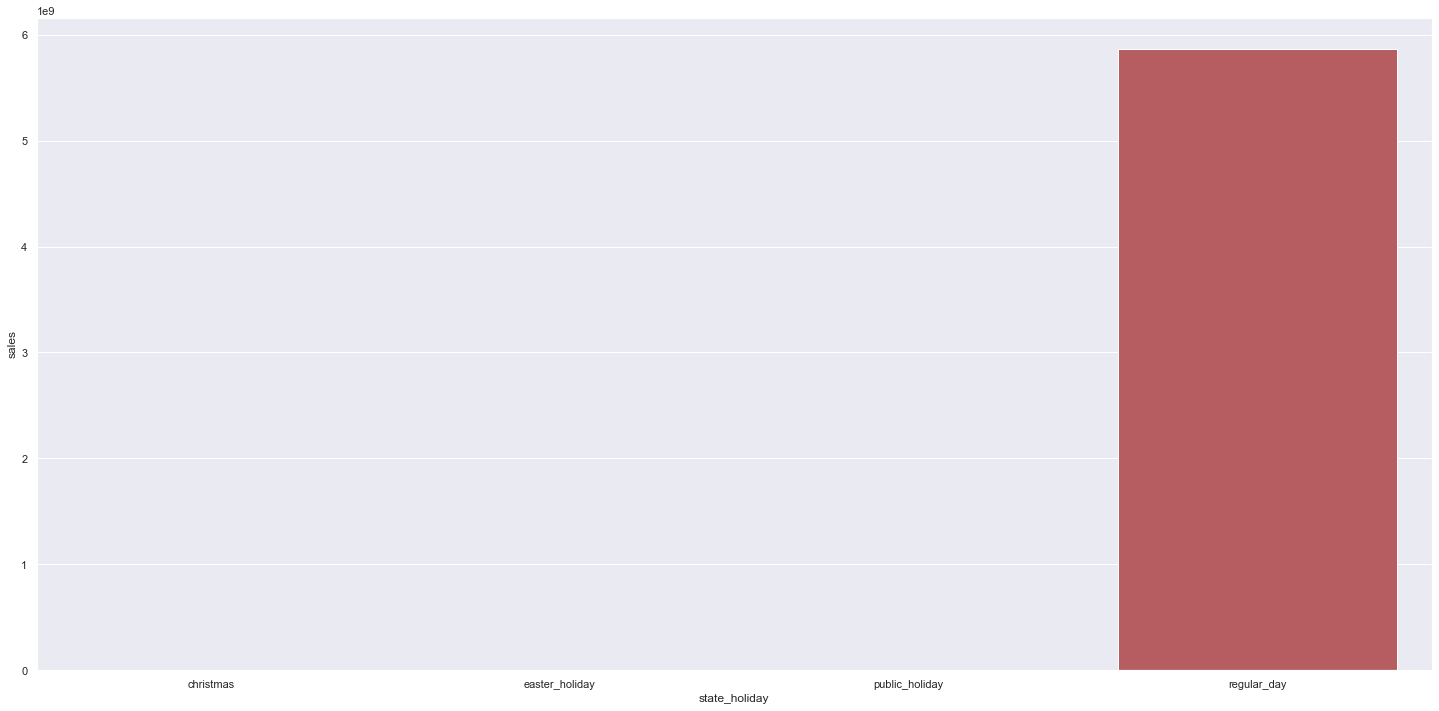

In [80]:
aux7_2 = df4[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux7_2)

<AxesSubplot:xlabel='state_holiday', ylabel='sales'>

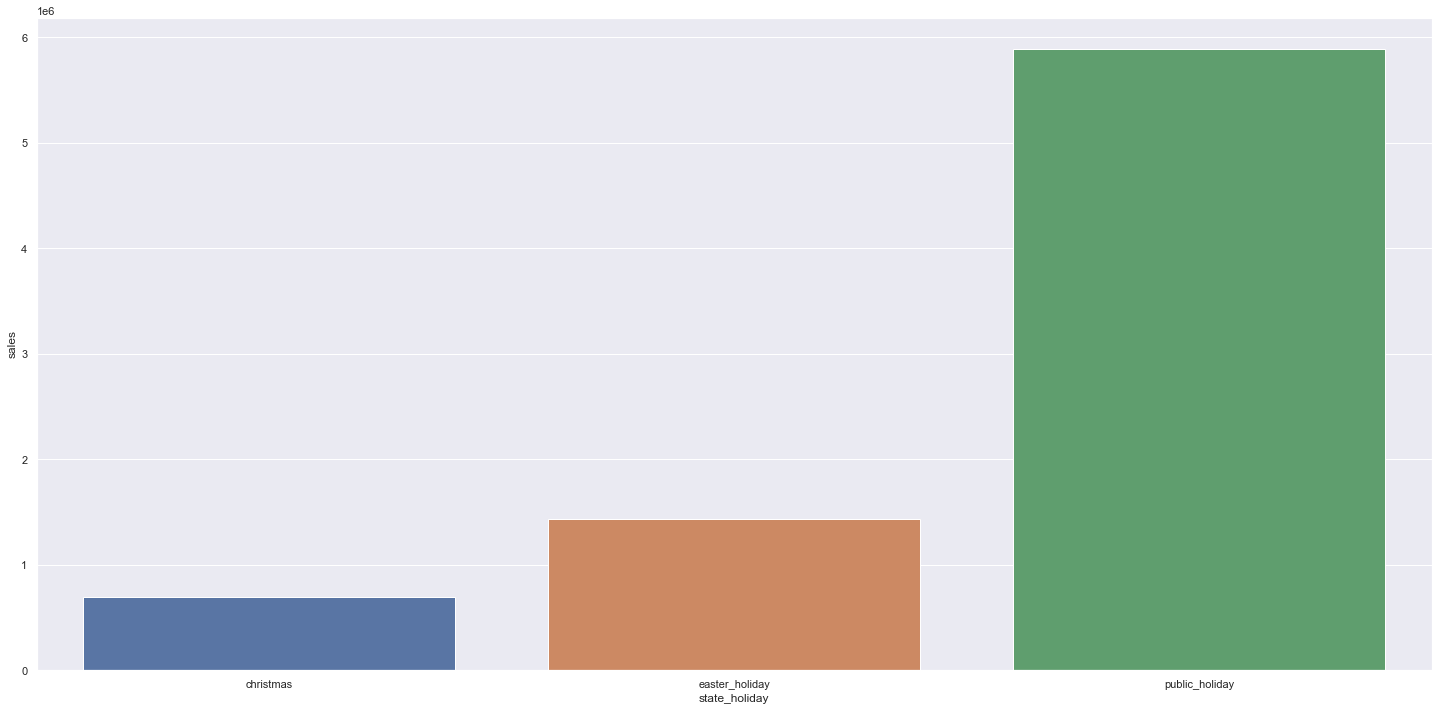

In [81]:
aux7 = df4[df4['state_holiday'] != 'regular_day']
aux7_3 = aux7[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux7_3)

Text(0.5, 1.0, 'Volume de vendas por feriado')

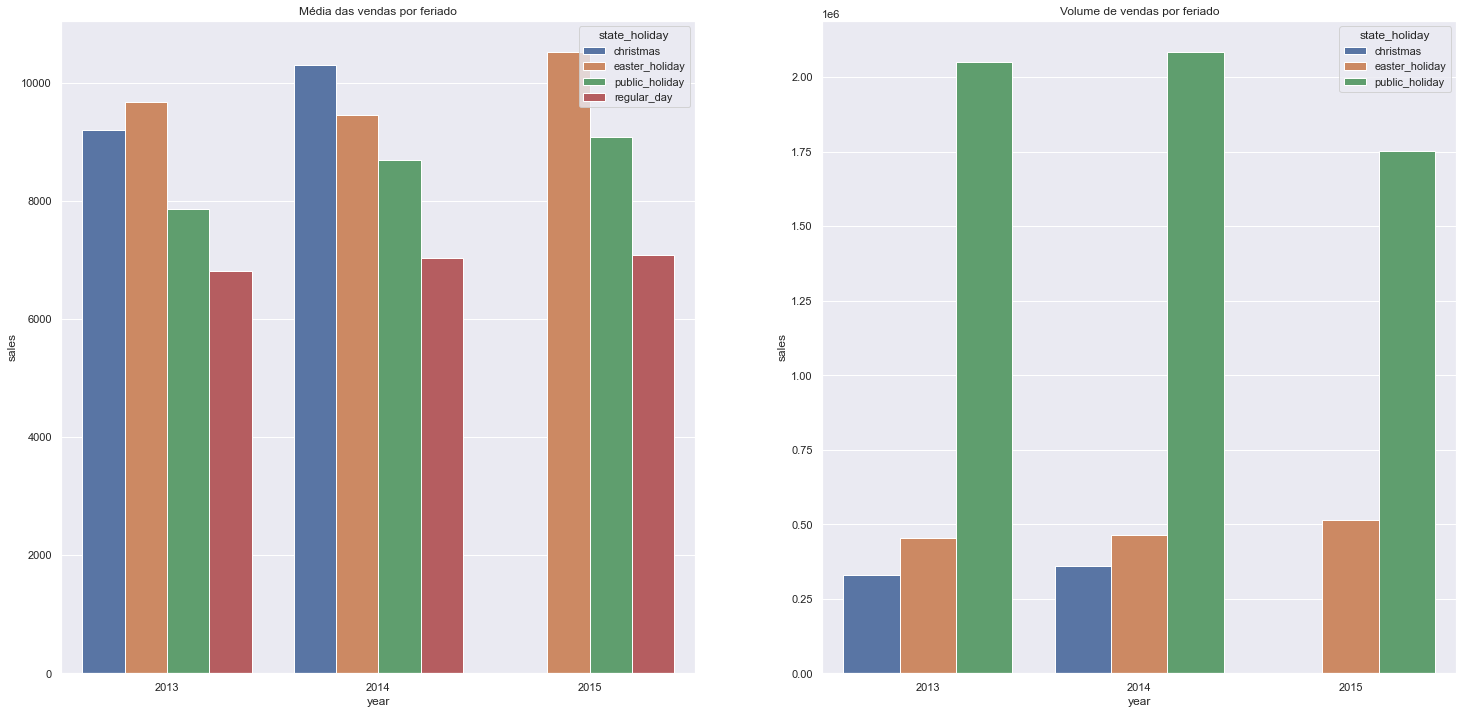

In [82]:
# média das vendas por feriados
plt.subplot(1,2,1)
aux7_4 = df4[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).mean().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux7_4)
plt.title('Média das vendas por feriado')

# volume de vendas por feriados
plt.subplot(1,2,2)
aux7_4 = aux7[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux7_4)
plt.title('Volume de vendas por feriado')

### H8. Lojas deveriam vender mais ao longo dos anos
Embora a média das vendas aumenta com os anos, o volume de vendas mostra cair ao longo dos anos.

<AxesSubplot:>

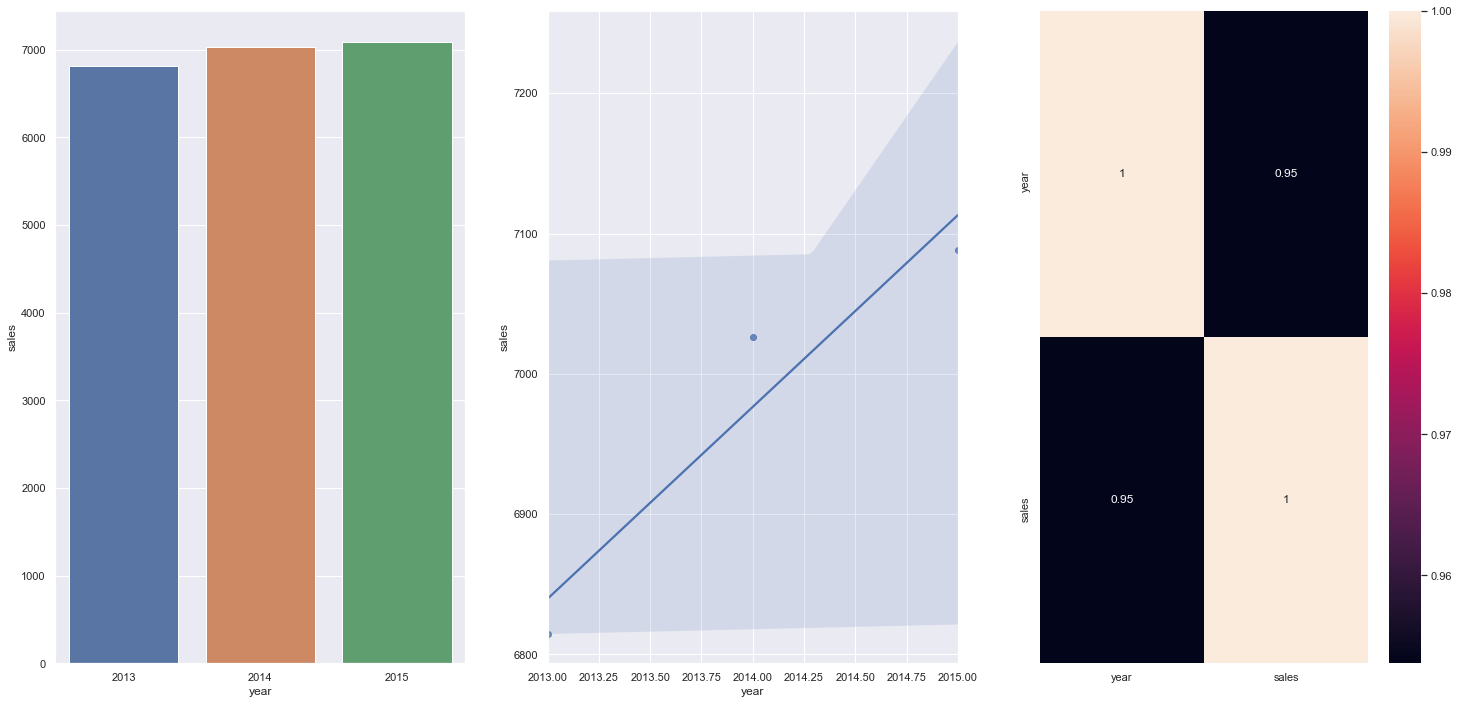

In [83]:
#média de vendas ao longo dos anos
aux8_1 = df4[['year', 'sales']].groupby('year').mean().reset_index()

plt.subplot( 1,3,1) 
sns.barplot(x='year', y='sales', data=aux8_1)

plt.subplot( 1,3,2) 
sns.regplot(x='year', y='sales', data=aux8_1)

plt.subplot( 1,3,3) 
sns.heatmap( aux8_1.corr(method='pearson'), annot=True )

<AxesSubplot:>

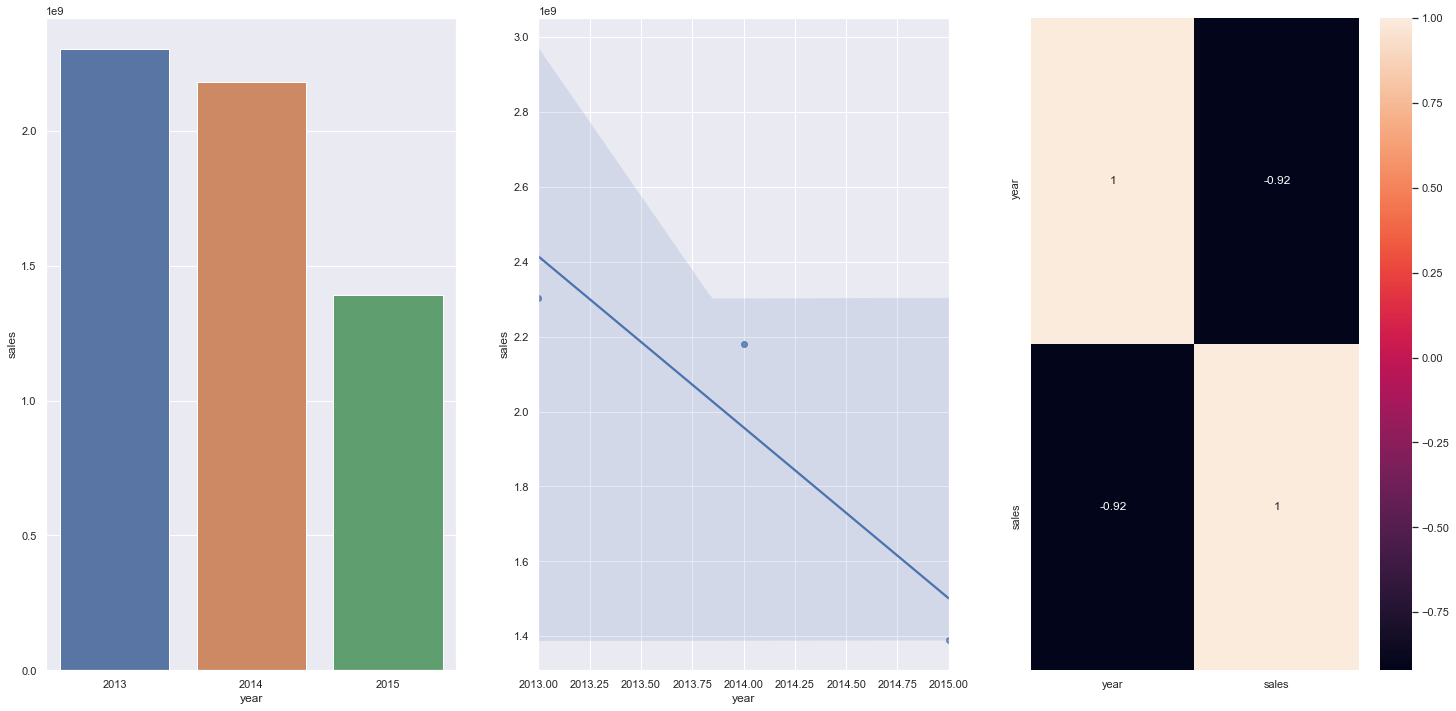

In [84]:
#volume de vendas ao longo dos anos
aux8_1 = df4[['year', 'sales']].groupby('year').sum().reset_index()
plt.subplot( 1,3,1) 
sns.barplot(x='year', y='sales', data=aux8_1)

plt.subplot( 1,3,2) 
sns.regplot(x='year', y='sales', data=aux8_1)

plt.subplot( 1,3,3) 
sns.heatmap( aux8_1.corr(method='pearson'), annot=True )

### H9. Lojas deveriam vender mais no segundo semestre do ano
A média das vendas aumentam em períodos de férias escolares (meio do ano e final do ano), mas o volume de vendas é maior no primeiro semestre!

<AxesSubplot:>

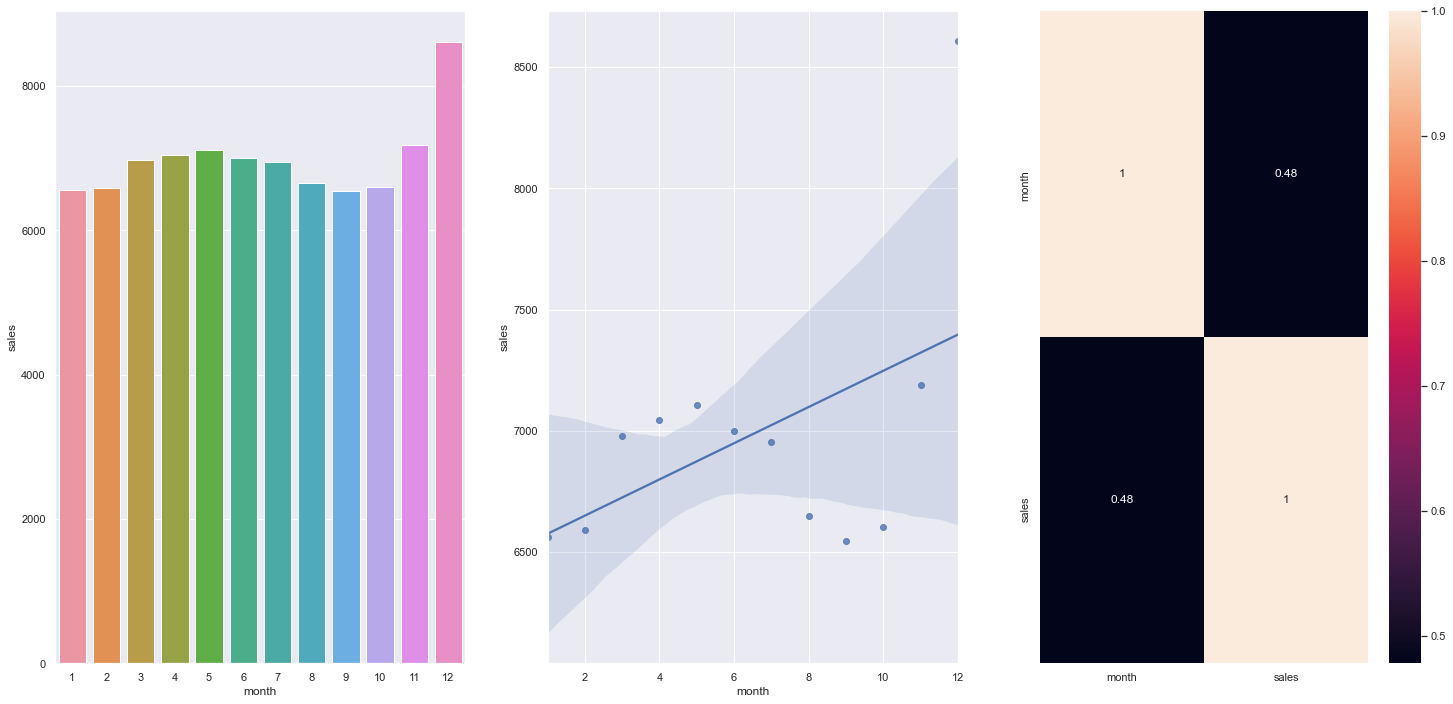

In [85]:
#média de vendas ao longo dos meses
aux8_1 = df4[['month', 'sales']].groupby('month').mean().reset_index()

plt.subplot( 1,3,1) 
sns.barplot(x='month', y='sales', data=aux8_1)

plt.subplot( 1,3,2) 
sns.regplot(x='month', y='sales', data=aux8_1)

plt.subplot( 1,3,3) 
sns.heatmap( aux8_1.corr(method='pearson'), annot=True )

<AxesSubplot:>

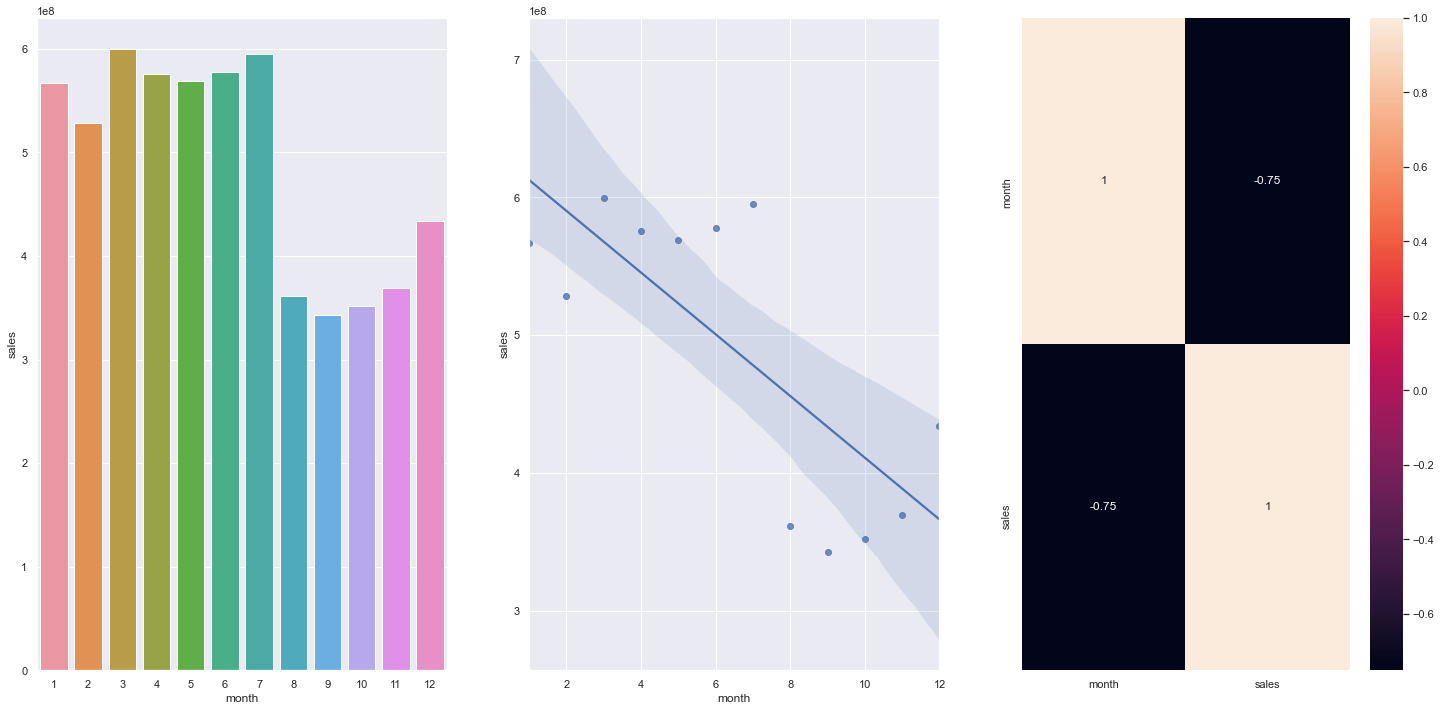

In [86]:
#volume de vendas ao longo dos meses
aux8_1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot( 1,3,1) 
sns.barplot(x='month', y='sales', data=aux8_1)

plt.subplot( 1,3,2) 
sns.regplot(x='month', y='sales', data=aux8_1)

plt.subplot( 1,3,3) 
sns.heatmap( aux8_1.corr(method='pearson'), annot=True )

### H10. Lojas deveriam vender mais depois do dia 10 de cada mês

Quando olhamos para a média das vendas por dia vemos uma alta no início, meio e fim do mês.<br>
No entanto, a média de vendas após o dia 10 é menor.<br>
Quando olhamos o volume de vendas por dia o comportamento se repete, mas como temos mais dias após o dia 10 (20 dias) o volume de vendas após o dia 10 é maior.


Text(0.5, 1.0, 'Média das vendas antes e depois do dia 10')

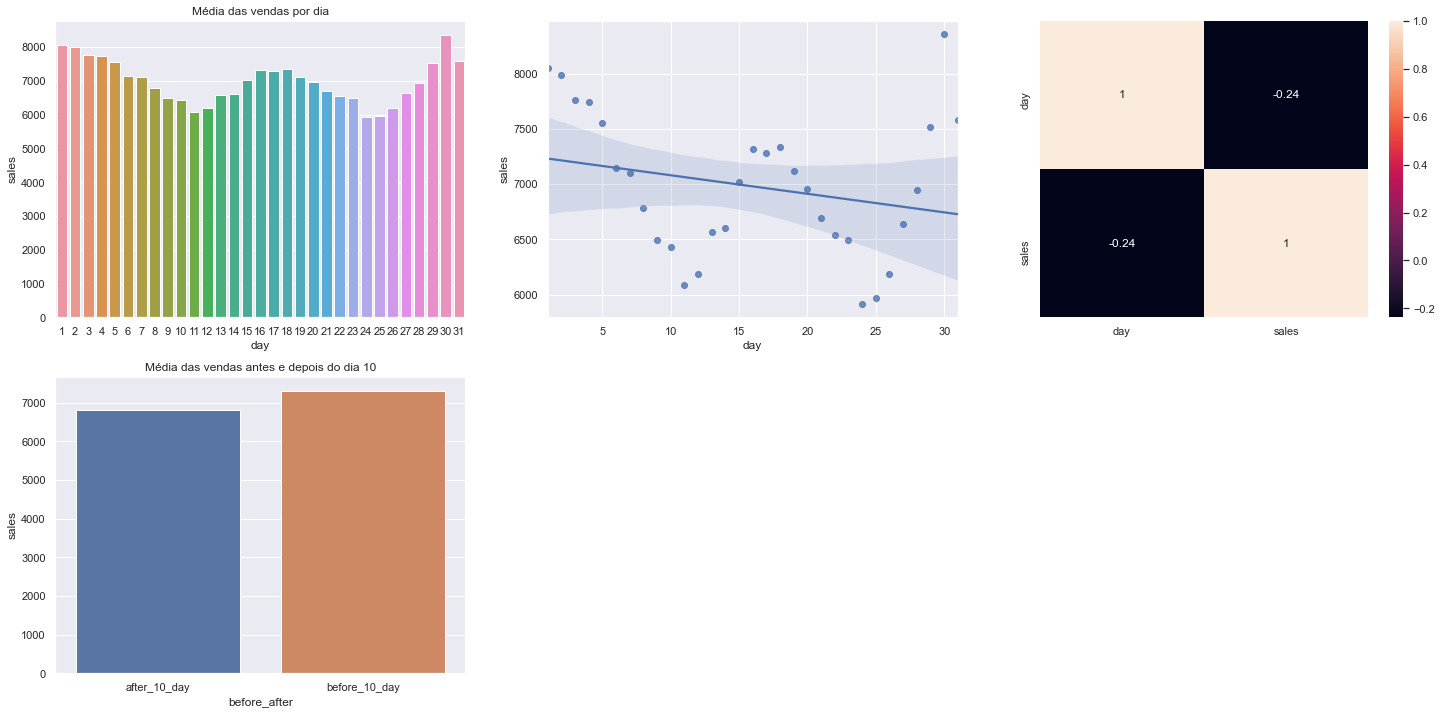

In [87]:
#média de vendas ao longo dos dias

aux10_1 = df4[['day', 'sales']].groupby('day').mean().reset_index()

plt.subplot( 2,3,1) 
sns.barplot(x='day', y='sales', data=aux10_1)
plt.title('Média das vendas por dia')

plt.subplot( 2,3,2) 
sns.regplot(x='day', y='sales', data=aux10_1)

plt.subplot( 2,3,3) 
sns.heatmap( aux10_1.corr(method='pearson'), annot=True )

#criando uma nova coluna classificatória de before and after 
aux10_1['before_after'] = aux10_1['day'].apply(lambda x: 'before_10_day' if x <= 10 else 'after_10_day')

aux10_2 = aux10_1[['before_after', 'sales']].groupby('before_after').mean().reset_index()

plt.subplot( 2,3,4) 
sns.barplot(x='before_after', y='sales', data=aux10_2)
plt.title('Média das vendas antes e depois do dia 10')





Text(0.5, 1.0, 'Volume de vendas antes e depois do dia 10')

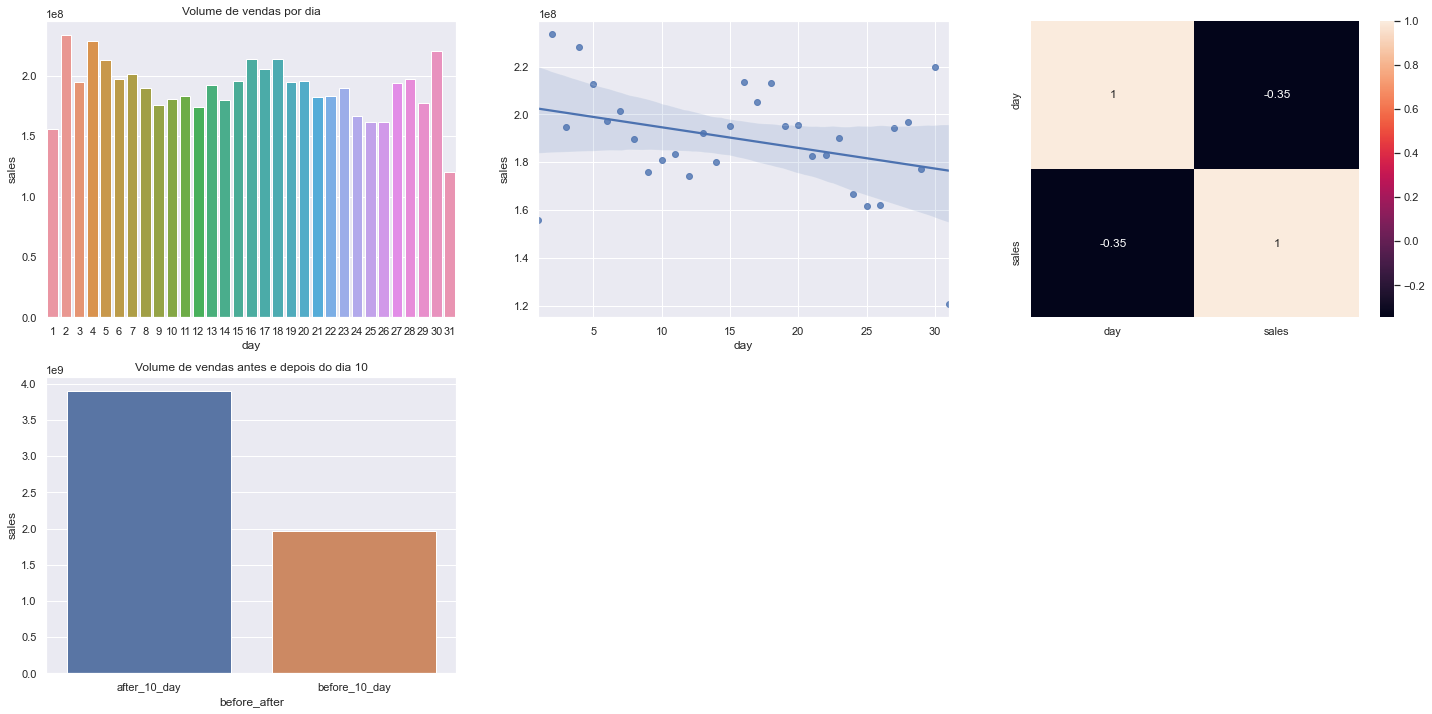

In [88]:
#Volume de vendas ao longo dos dias

aux10_1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot( 2,3,1) 
sns.barplot(x='day', y='sales', data=aux10_1)
plt.title('Volume de vendas por dia')

plt.subplot( 2,3,2) 
sns.regplot(x='day', y='sales', data=aux10_1)

plt.subplot( 2,3,3) 
sns.heatmap( aux10_1.corr(method='pearson'), annot=True )

#criando uma nova coluna classificatória de before and after 
aux10_1['before_after'] = aux10_1['day'].apply(lambda x: 'before_10_day' if x <= 10 else 'after_10_day')

aux10_2 = aux10_1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot( 2,3,4) 
sns.barplot(x='before_after', y='sales', data=aux10_2)
plt.title('Volume de vendas antes e depois do dia 10')

### H11. Lojas deveriam vender menos aos finais de semana
Verdadeira: lojas vendem menos nos finais de semanas.

<AxesSubplot:>

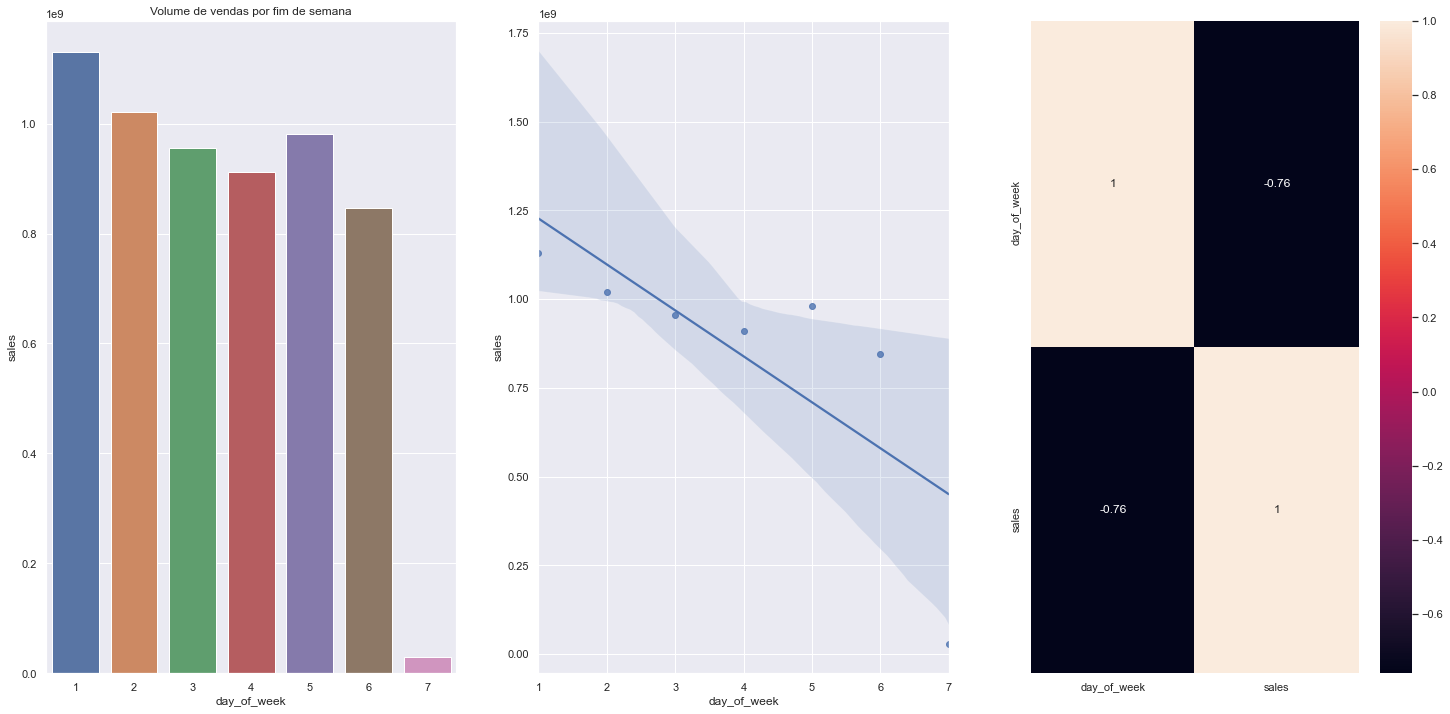

In [89]:
#Volume de vendas nos finais de semana

aux11_1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot( 1,3,1) 
sns.barplot(x='day_of_week', y='sales', data=aux11_1)
plt.title('Volume de vendas por fim de semana')

plt.subplot( 1,3,2) 
sns.regplot(x='day_of_week', y='sales', data=aux11_1)

plt.subplot( 1,3,3) 
sns.heatmap( aux11_1.corr(method='pearson'), annot=True )


### H12. Lojas deveriam vender menos durante os feriados escolares
O volume de vendas das lojas é menor em feriado escolar, este fato pode ser devido ao tempo de feriado escolar ser menor. No entanto, quando olhamos para a média das vendas no período escolar, vemos um pequeno aumento.<br>
Olhando mês a mês, notamos um aumento do volume de vendas nos períodos de férias escolar (julho e agosto). Jé quando olhamos para as médias de vendas, as médias dos feriados escolares superam todos os meses exceto o mês de dezembro.

<AxesSubplot:xlabel='month', ylabel='sales'>

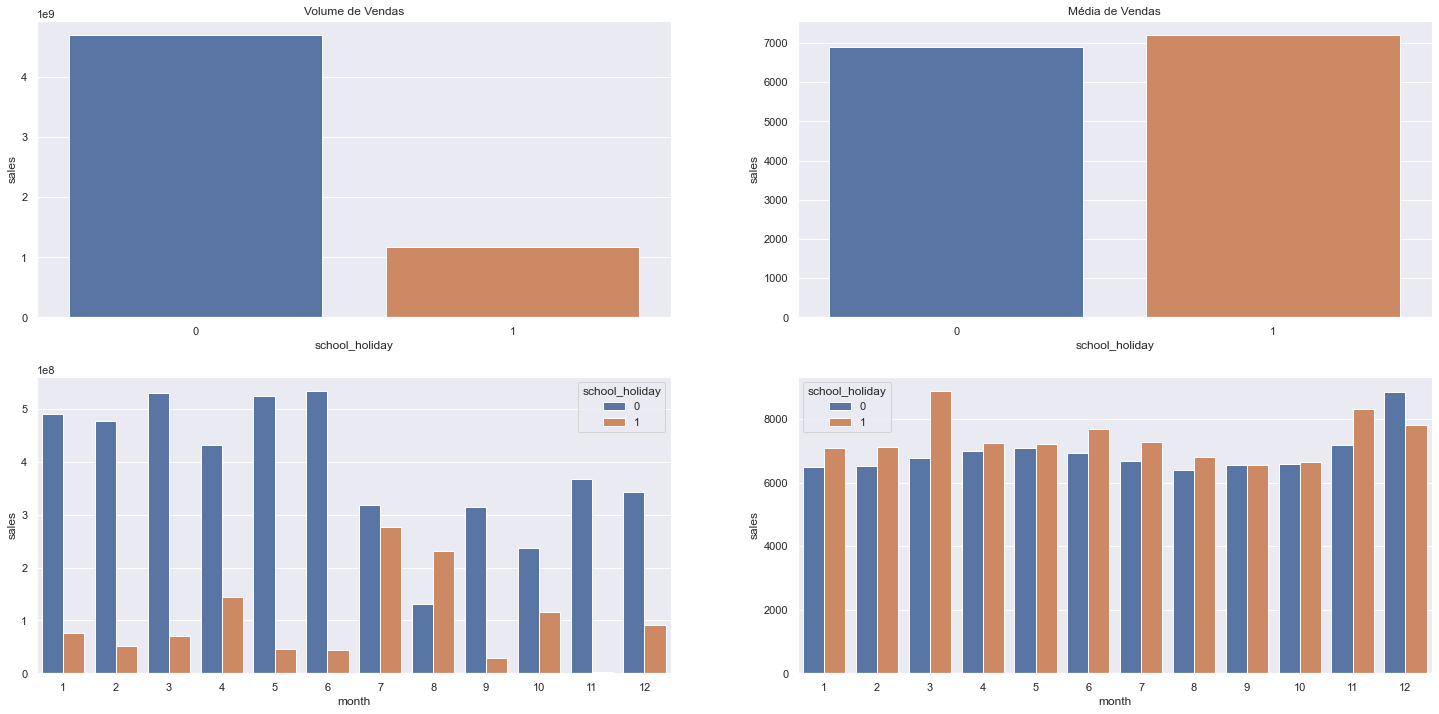

In [90]:
# volume de vendas nos feriados escolares
aux12_1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
plt.subplot(2,2,1)
sns.barplot(x='school_holiday', y='sales', data =aux12_1)
plt.title('Volume de Vendas')

plt.subplot(2,2,3)
aux12_2 = df4[['month','school_holiday', 'sales']].groupby(['month','school_holiday']).sum().reset_index()
sns.barplot(x='month', y='sales', hue='school_holiday', data =aux12_2)

# média de vendas nos feriados escolares
aux12_1 = df4[['school_holiday', 'sales']].groupby('school_holiday').mean().reset_index()
plt.subplot(2,2,2)
sns.barplot(x='school_holiday', y='sales', data =aux12_1)
plt.title('Média de Vendas')

plt.subplot(2,2,4)
aux12_2 = df4[['month','school_holiday', 'sales']].groupby(['month','school_holiday']).mean().reset_index()
sns.barplot(x='month', y='sales', hue='school_holiday', data =aux12_2)

### 4.2.1 Resumos das Hipóteses

In [91]:
tab = [['Hipotese', 'Conclusao', 'Releviancia'],
       ['H1', 'Verdadeira', 'Media'],
       ['H2', 'Falsa', 'Baixa'],
       ['H3', 'Falsa', 'Media'],
       ['H4', 'Falsa', 'Baixa'],
       ['H5', '-', '-'],
       ['H6', 'Falsa', 'Baixa'],
       ['H7', 'Falsa', 'Media'],
       ['H8', 'Falsa', 'Alta'],
       ['H9', 'Falsa', 'Alta'],
       ['H10', 'Verdadeira', 'Baixa'],
       ['H11', 'Verdadeira', 'Alta'],
       ['H12', 'Falsa', 'Baixa']]
print( tabulate ( tab, headers = 'firstrow' ) )

Hipotese    Conclusao    Releviancia
----------  -----------  -------------
H1          Verdadeira   Media
H2          Falsa        Baixa
H3          Falsa        Media
H4          Falsa        Baixa
H5          -            -
H6          Falsa        Baixa
H7          Falsa        Media
H8          Falsa        Alta
H9          Falsa        Alta
H10         Verdadeira   Baixa
H11         Verdadeira   Alta
H12         Falsa        Baixa


## Análise Multivariada

### 4.3.1 Atributos numéricos (numerical attributes)

<AxesSubplot:>

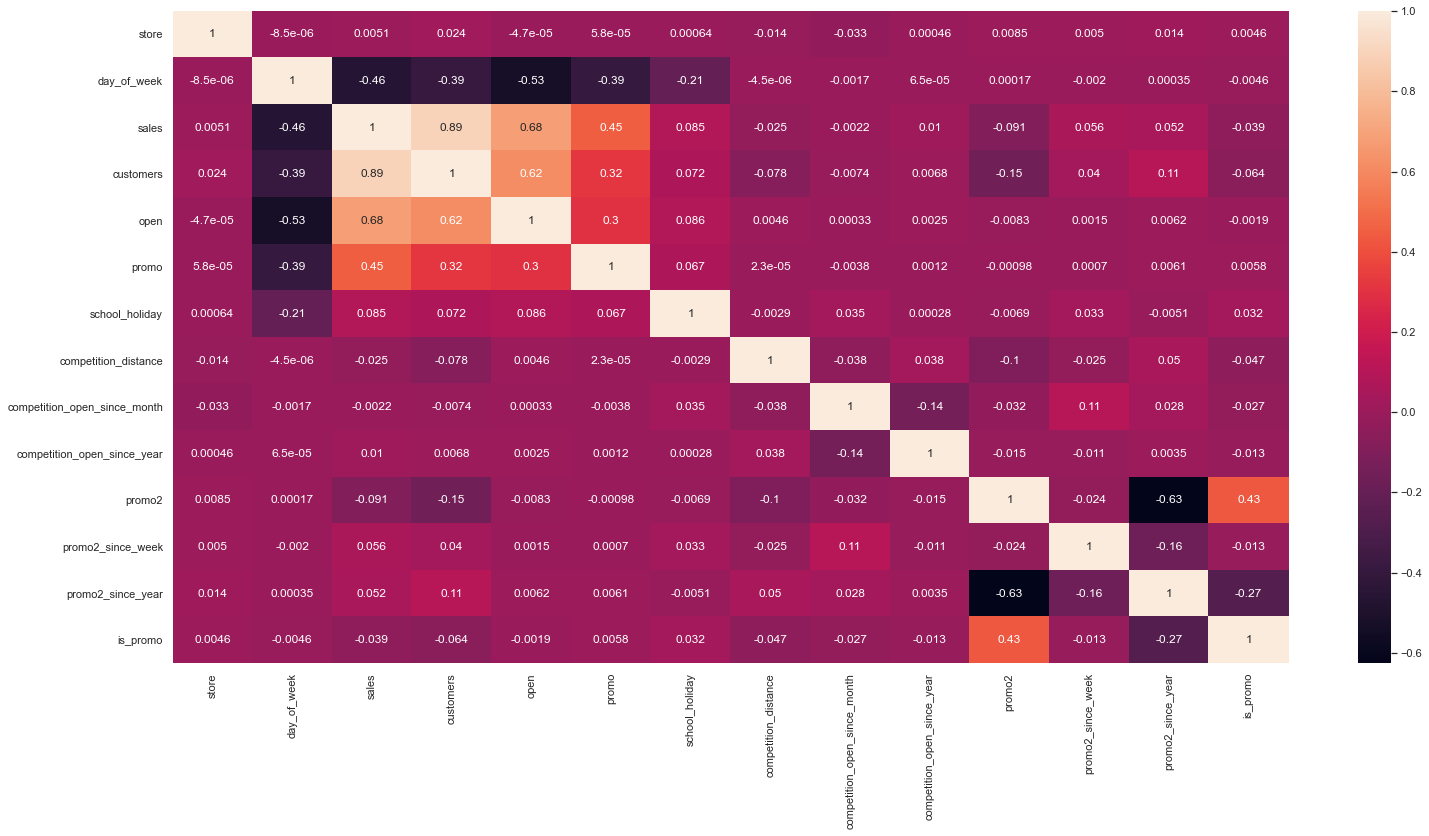

In [92]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True )

### 4.3.2 Atributos categóricos (Categorical Attributes)

In [93]:
a = df4.select_dtypes(include= 'object')
a.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


In [94]:
#cm  confusion matrix


In [95]:
# Cramer_v calculate from confusion matrix (funções auxiliares)
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
               'store_type': [a4, a5, a6],
               'assortment': [a7, a8, a9] } )
#final dataset
d = d.set_index(d.columns)

<AxesSubplot:>

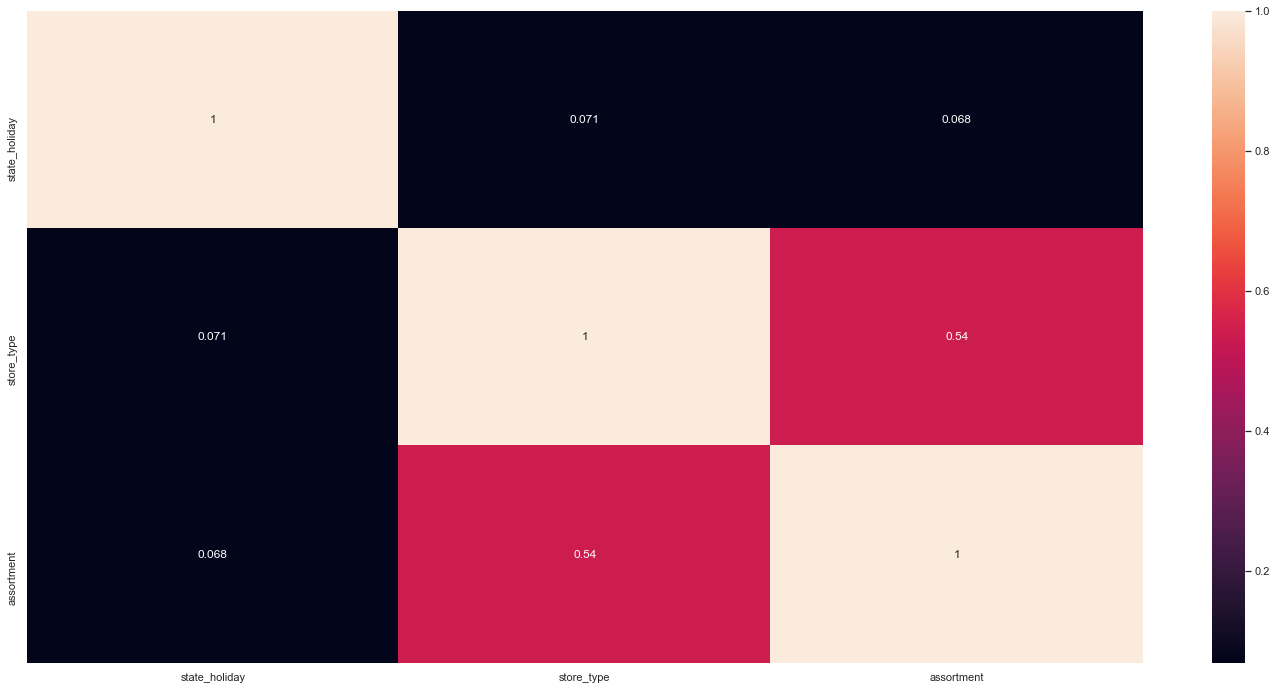

In [96]:
sns.heatmap( d, annot=True )

#### 

## 5.0 PREPARAÇÃO DOS DADOS

In [97]:
df5 = df4.copy()

### 5.1Normalização

Analisando a seção 4.1 Análise univariada seção 4.1.2 numérica, vemos nos gráficos apresentados que não temos nenhuma categoria numérica com distribuição normal. Portanto, para este caso não faremos nenhuma normalização.

### 5.2 Reescaling

Verifica qual variável possui outliers ou não para a seguinte aplicação:<br>
Com outliers -> robust scaling<br>
Sem outliers -> min-max scaling

In [98]:
a = df5.select_dtypes( include = ['float64', 'int64'] )

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='competition_time_month'>

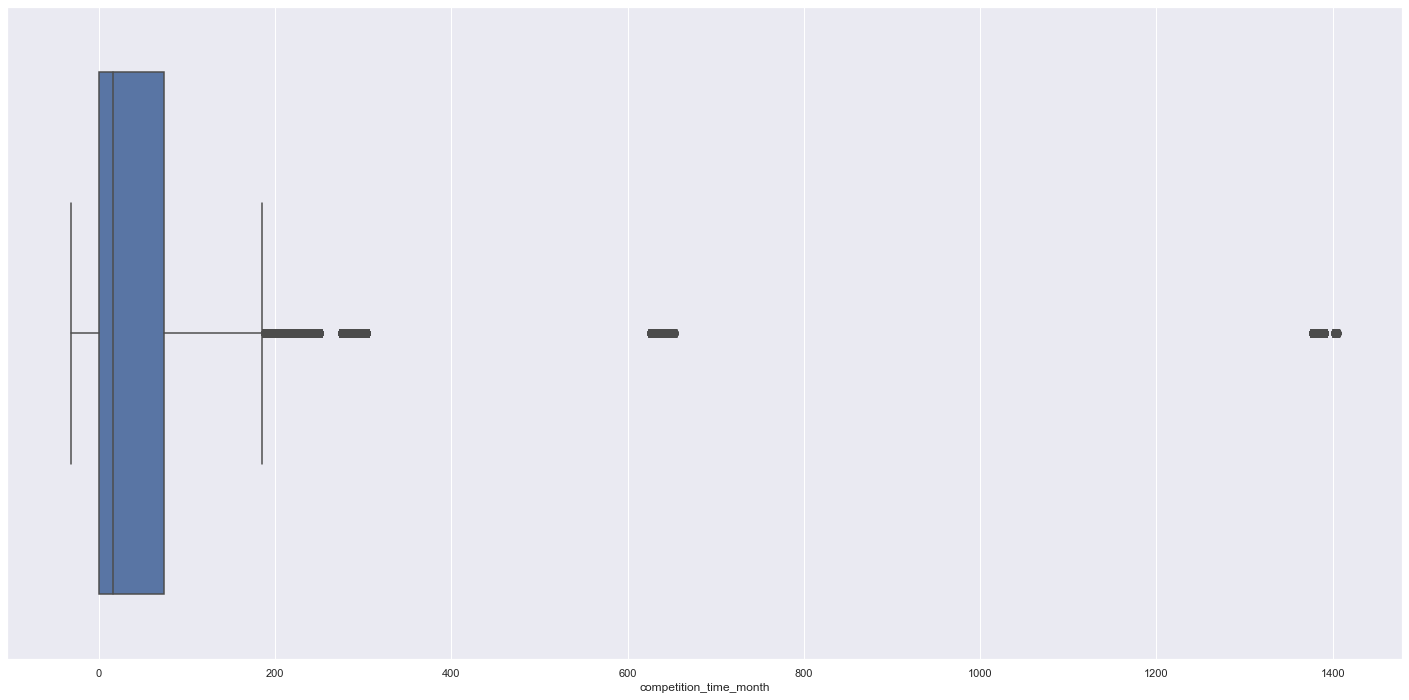

In [99]:
sns.boxplot(a['competition_time_month'])

In [100]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values)
# year
df5['year'] = mms.fit_transform( df5[['year']].values)
# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values)
# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values)

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='year', ylabel='Density'>

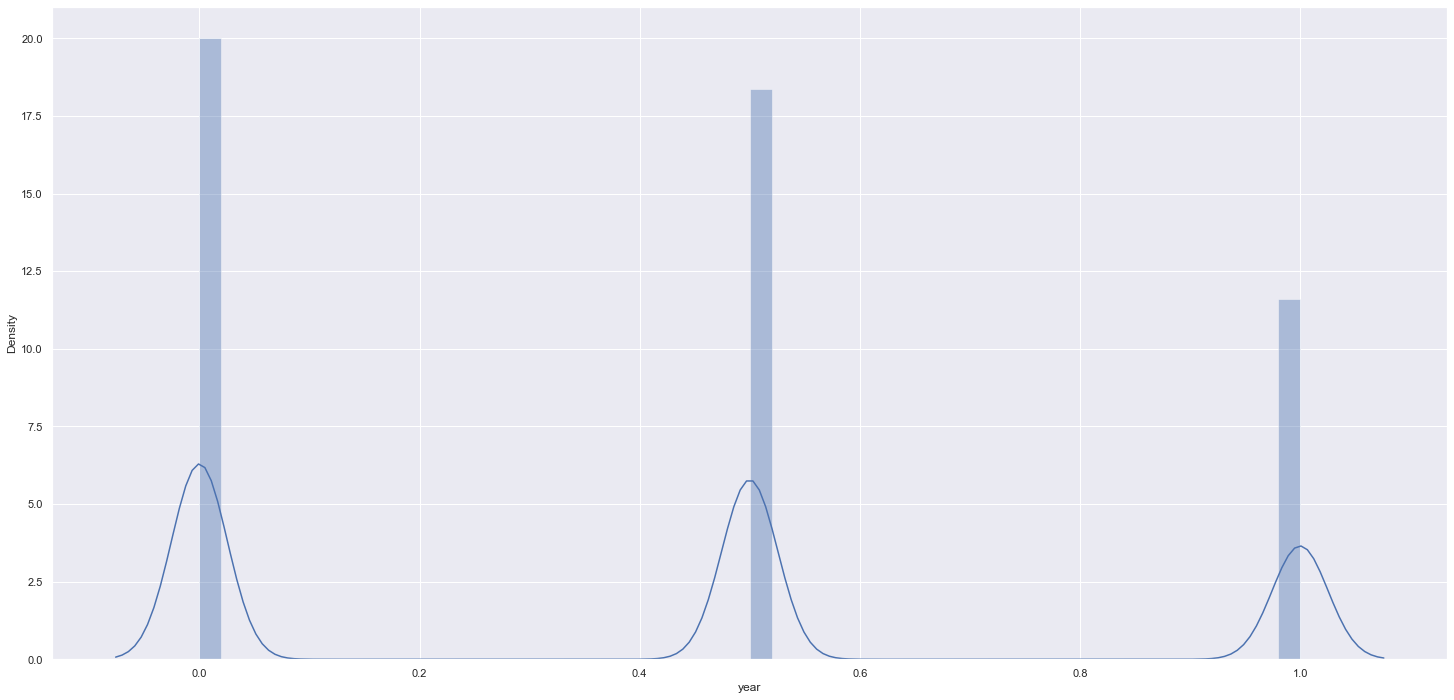

In [101]:
sns.distplot(df5['year'])

### 5.3 Transformação

### 5.3.1 Variavel categórica

In [114]:
#state_holiday - One Hot Encoding indicado para variaveis que indicam 'estados'
df5 = pd.get_dummies( df5, prefix = ['state_holiday'], columns = ['state_holiday'] )

#store_type - Lable Encoding: quando não apresenta ordem e nem estado.
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )

#assortment - Ordinal Encoding : variável que indica uma determinada ordem (basic, extra, extended)
assortment_dict = {'basic':1, 'extra':2, 'extended':3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

In [115]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,week,week_of_year,day,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,6064,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,4822,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1


Variáveis cíclicas

In [ ]:
# day of week
# month
# day
# week of year